<a href="https://colab.research.google.com/github/AbdusSattar2025/Assignments/blob/main/CIC_4th_Assgt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet dscribe ase scikit-learn matplotlib pandas tqdm
!pip install --quiet rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.4/777.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 52.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import time
import zipfile
import os
from tqdm.notebook import tqdm # Use notebook tqdm for Colab

from ase.io import read
from dscribe.descriptors import CoulombMatrix, MBTR
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
# Load the QM9 dataset (subset of 5K molecules)

# The zip file contains individual .xyz files.
# Need to extract information from these .xyz files.
# Based on the output of cell fbbcbc22, each .xyz file contains molecular data
# including SMILES strings and QM9 properties in a specific format.

import io

# Define QM9 property names (tag + gdb_id + 14 QM9 properties)
# Only define if not already present to avoid overwriting previous definitions in the notebook.
if 'QM9_PROP_NAMES' not in globals():
    QM9_PROP_NAMES = [
        'tag', 'gdb_id', 'A', 'B', 'C', 'mu', 'alpha',
        'HOMO', 'LUMO', 'gap', 'R2', 'ZPVE', 'U0', 'U', 'H', 'G'
    ]

# Set number of files to process (default to 5000 as a subset). Do not overwrite if already set.
if 'N_FILES' not in globals():
    N_FILES = 5000

# Use a raw string or forward slashes to avoid unicode escape issues with backslashes
# Corrected path after uploading to Colab
ZIP_PATH = '/content/QM9.zip'

all_data = []

try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        # Get list of files within the specified inner folder
        # Assuming files are directly under the zip or in a known subfolder like 'dsgdb9nsd.xyz/'
        # Let's list files and filter for .xyz, adjusting path if necessary
        file_list = [f for f in z.namelist() if f.endswith('.xyz')]

        # Select N_FILES or fewer if there aren't enough files
        files_to_process = file_list[:N_FILES]

        print(f"Processing {len(files_to_process)} files from the zip archive...")

        for file_path in files_to_process:
            with z.open(file_path) as f:
                xyz_text = f.read().decode('utf-8')
                lines = xyz_text.strip().split('\n')

                # Extract properties from the second line
                # The format appears to be: tag gdb_id A B C mu alpha HOMO LUMO gap R2 ZPVE U0 U H G
                props_line = lines[1].split()
                # Ensure there are enough values to match QM9_PROP_NAMES (excluding smiles and InChI)
                # The QM9_PROP_NAMES includes 'tag' and 'gdb_id' at the beginning.
                # The second line of the .xyz file contains tag, gdb_id, and the 14 properties.
                # Total of 16 values expected on the second line.
                if len(props_line) >= 16:
                    data_row = {QM9_PROP_NAMES[i]: props_line[i] for i in range(16)}

                    # Extract SMILES from the second to last line
                    smiles_line = lines[-2].split()
                    if len(smiles_line) >= 1:
                         data_row['smiles_canonical'] = smiles_line[0]
                    else:
                         data_row['smiles_canonical'] = None # Or handle missing SMILES as needed

                    all_data.append(data_row)
                else:
                    print(f"Skipping file {file_path}: Incorrect number of properties on the second line.")


except FileNotFoundError:
    print(f"Error: ZIP file not found at {ZIP_PATH}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

# Create DataFrame from collected data
df = pd.DataFrame(all_data)

# Convert relevant columns to numeric types, coercing errors
numeric_cols = QM9_PROP_NAMES[2:] # Exclude 'tag' and 'gdb_id'
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Display the first few rows and the shape of the DataFrame
display(df.head())
print(df.shape)

Processing 5000 files from the zip archive...


tag gdb_id          A           B           C      mu  alpha    HOMO  \
0  gdb      1  157.71180  157.709970  157.706990  0.0000  13.21 -0.3877   
1  gdb      2  293.60975  293.541110  191.393970  1.6256   9.46 -0.2570   
2  gdb      3  799.58812  437.903860  282.945450  1.8511   6.31 -0.2928   
3  gdb      4    0.00000   35.610036   35.610036  0.0000  16.28 -0.2845   
4  gdb      5    0.00000   44.593883   44.593883  2.8937  12.99 -0.3604   

     LUMO     gap       R2      ZPVE         U0          U          H  \
0  0.1171  0.5048  35.3641  0.044749 -40.478930 -40.476062 -40.475117   
1  0.0829  0.3399  26.1563  0.034358 -56.525887 -56.523026 -56.522082   
2  0.0687  0.3615  19.0002  0.021375 -76.404702 -76.401867 -76.400922   
3  0.0506  0.3351  59.5248  0.026841 -77.308427 -77.305527 -77.304583   
4  0.0191  0.3796  48.7476  0.016601 -93.411888 -93.409370 -93.408425   

           G smiles_canonical  
0 -40.498597                C  
1 -56.544961                N  
2 -76.422349                O  
3 -77.327429              C#C  
4 -93.431246              C#N

(5000, 17)


In [ ]:
# Read and display the content of a specific .xyz file from the zip archive
# The file needs to be uploaded to the Colab environment first.
# After uploading, it will be in the /content/ directory.
ZIP_PATH = '/content/QM9.zip' # Corrected path after uploading

try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        # Specify the path within the zip archive
        inner_file_path = 'dsgdb9nsd.xyz/dsgdb9nsd_075700.xyz'
        if inner_file_path in z.namelist():
            with z.open(inner_file_path) as file:
                print(f"Content of {inner_file_path}:")
                for line in file:
                    print(line.decode('utf-8'), end='')
        else:
            print(f"Error: File '{inner_file_path}' not found within the zip archive.")

except FileNotFoundError:
    print(f"Error: ZIP file not found at {ZIP_PATH}. Please ensure you have uploaded it.")
except Exception as e:
    print(f"An error occurred: {e}")

Content of dsgdb9nsd.xyz/dsgdb9nsd_075700.xyz:
16
gdb 75700	2.29421	2.10153	1.19281	1.5927	71.76	-0.2569	-0.021	0.2359	1002.3496	0.125963	-434.09168	-434.083979	-434.083035	-434.123886	28.894	
C	 0.0082723652	 1.4385040241	 0.0216304465	-0.368015
N	-0.0080626856	-0.0080486441	-0.0143324088	-0.128223
C	-0.0025221437	-0.7715337629	-1.1909538518	 0.388126
N	 0.0263387403	-0.3906951642	-2.3959782595	-0.532716
N	-0.0435539427	-2.1606959554	-0.8372214133	-0.113662
C	 1.1983737221	-2.6000297832	-0.1756188576	-0.242408
C	 0.0113061798	-2.2080435108	 0.6349537932	-0.162296
C	-0.0270216144	-0.7926214222	 1.1346516211	 0.42506
O	-0.0955434019	-0.3870203764	 2.2694066024	-0.371241
H	 0.9216696532	 1.8340504971	-0.4354195835	 0.141444
H	-0.8595819793	 1.8482562075	-0.5050019382	 0.146272
H	-0.0319704226	 1.7357251605	 1.0706204257	 0.173704
H	 0.0660884133	 0.6248858104	-2.4690959743	 0.222945
H	 1.4244948343	-3.6539669067	-0.2978095694	 0.14517
H	 2.0547706395	-1.9318987311	-0.1997156332	 0.140887

# Compute Molecular Representations

I will compute two types of representations:
1. **Eigenvalues of Coulomb Matrix (EV-CM)**: Sorted eigenvalues provide a permutation-invariant representation
2. **Many-Body Tensor Representation (MBTR)**: Captures geometric and chemical information through distribution functions

In [ ]:
# Step 1: Read molecular structures from the zip file and store as ASE Atoms objects

print("Reading molecular structures from the dataset...")
molecules = []
molecule_ids = []

from ase import Atoms

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    file_list = [f for f in z.namelist() if f.endswith('.xyz')]
    files_to_process = file_list[:N_FILES]

    for file_path in tqdm(files_to_process, desc="Loading molecules"):
        try:
            with z.open(file_path) as f:
                xyz_text = f.read().decode('utf-8')
                lines = xyz_text.strip().split('\n')

                # Extract number of atoms from first line
                n_atoms = int(lines[0].strip())

                # Parse atomic coordinates (lines 2 to n_atoms+1)
                # Format: Element X Y Z [optional: partial_charge]
                symbols = []
                positions = []

                for i in range(2, min(2 + n_atoms, len(lines))):
                    parts = lines[i].split()
                    if len(parts) >= 4:
                        symbols.append(parts[0])  # Element symbol
                        # X, Y, Z coordinates
                        positions.append([float(parts[1]), float(parts[2]), float(parts[3])])

                # Create ASE Atoms object manually
                if len(symbols) == n_atoms and len(positions) == n_atoms:
                    atoms = Atoms(symbols=symbols, positions=positions)
                    molecules.append(atoms)

                    # Extract molecule ID from filename
                    mol_id = os.path.basename(file_path).replace('.xyz', '')
                    molecule_ids.append(mol_id)
                else:
                    print(f"Warning: Mismatch in atom count for {file_path}")

        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

print(f"Successfully loaded {len(molecules)} molecular structures")
if len(molecules) > 0:
    print(f"Example molecule: {molecules[0].get_chemical_formula()}")
    print(f"Example molecule has {len(molecules[0])} atoms")
else:
    print("No molecules were loaded! Please check the data format.")

Reading molecular structures from the dataset...


Loading molecules:   0%|          | 0/5000 [00:00<?, ?it/s]

Error reading dsgdb9nsd.xyz/dsgdb9nsd_000212.xyz: could not convert string to float: '2.1997*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_001460.xyz: could not convert string to float: '8.7582*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_001513.xyz: could not convert string to float: '-9.9614*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_001616.xyz: could not convert string to float: '1.2346*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_002091.xyz: could not convert string to float: '3.863*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_002624.xyz: could not convert string to float: '-2.2967*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_002693.xyz: could not convert string to float: '-8.7796*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_002993.xyz: could not convert string to float: '-2.4362*^-6'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_003299.xyz: could not convert string to float: '-5.612*^-7'
Error reading dsgdb9nsd.xyz/dsgdb9nsd_003454.xyz: could not convert string to float: '-8.5151*^-6'
Error reading ds

In [ ]:
# Step 2: Compute Eigenvalues of Coulomb Matrix (EV-CM)

print("Computing Coulomb Matrix Eigenvalues...")

# Get all unique species in the dataset
all_species = set()
for mol in molecules:
    all_species.update(mol.get_chemical_symbols())
all_species = sorted(list(all_species))

print(f"Unique atomic species in dataset: {all_species}")

# Initialize Coulomb Matrix descriptor
# n_atoms_max should be set to the maximum number of atoms in your dataset
max_atoms = max([len(mol) for mol in molecules])
print(f"Maximum number of atoms in a molecule: {max_atoms}")

cm = CoulombMatrix(
    n_atoms_max=max_atoms,
    permutation="eigenspectrum"  # This gives us sorted eigenvalues (EV-CM)
)

# Compute CM eigenvalues for all molecules
evcm_features = []
start_time = time.time()

for mol in tqdm(molecules, desc="Computing EV-CM"):
    try:
        cm_eigenvalues = cm.create(mol)
        evcm_features.append(cm_eigenvalues)
    except Exception as e:
        print(f"Error computing CM for molecule: {e}")
        # Append zeros if computation fails
        evcm_features.append(np.zeros(max_atoms))

evcm_features = np.array(evcm_features)

print(f"EV-CM computation completed in {time.time() - start_time:.2f} seconds")
print(f"EV-CM feature shape: {evcm_features.shape}")
print(f"Each molecule is represented by {evcm_features.shape[1]} eigenvalues")

Computing Coulomb Matrix Eigenvalues...
Unique atomic species in dataset: ['C', 'F', 'H', 'N', 'O']
Maximum number of atoms in a molecule: 23


Computing EV-CM:   0%|          | 0/4981 [00:00<?, ?it/s]

EV-CM computation completed in 0.30 seconds
EV-CM feature shape: (4981, 23)
Each molecule is represented by 23 eigenvalues


In [ ]:
# Step 3: Compute Many-Body Tensor Representation (MBTR)

print("Computing MBTR features...")

# Initialize MBTR descriptor
# MBTR captures k=1 (atomic), k=2 (pairwise), and k=3 (three-body) interactions
mbtr = MBTR(
    species=all_species,
    geometry={"function": "inverse_distance"},  # k=2: geometry based on inverse distances
    grid={"min": 0, "max": 1, "n": 100, "sigma": 0.1},  # Grid for discretization
    weighting={"function": "exp", "scale": 0.5, "threshold": 1e-3},  # Valid weighting functions: 'exp', 'inverse_square', 'unity'
    periodic=False,  # QM9 molecules are non-periodic
    normalization="l2"  # L2 normalization
)

# Compute MBTR for all molecules
mbtr_features = []
start_time = time.time()

for mol in tqdm(molecules, desc="Computing MBTR"):
    try:
        mbtr_vector = mbtr.create(mol)
        mbtr_features.append(mbtr_vector)
    except Exception as e:
        print(f"Error computing MBTR for molecule: {e}")
        # Append zeros if computation fails
        mbtr_features.append(np.zeros(mbtr.get_number_of_features()))

mbtr_features = np.array(mbtr_features)

print(f"MBTR computation completed in {time.time() - start_time:.2f} seconds")
print(f"MBTR feature shape: {mbtr_features.shape}")
print(f"Each molecule is represented by {mbtr_features.shape[1]} MBTR features")

Computing MBTR features...


Computing MBTR:   0%|          | 0/4981 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/dscribe/core/system.py:96: FutureWarning: Please use atoms.calc
  calculator=atoms.get_calculator(),


MBTR computation completed in 5.30 seconds
MBTR feature shape: (4981, 1500)
Each molecule is represented by 1500 MBTR features


In [ ]:
# Display summary of computed representations

print("="*60)
print("SUMMARY OF COMPUTED REPRESENTATIONS")
print("="*60)
print(f"\nNumber of molecules processed: {len(molecules)}")
print(f"\nEV-CM (Eigenvalues of Coulomb Matrix):")
print(f"  - Feature dimension: {evcm_features.shape[1]}")
print(f"  - Feature matrix shape: {evcm_features.shape}")
print(f"  - Example (first molecule): {evcm_features[0][:5]}... (showing first 5 eigenvalues)")

print(f"\nMBTR (Many-Body Tensor Representation):")
print(f"  - Feature dimension: {mbtr_features.shape[1]}")
print(f"  - Feature matrix shape: {mbtr_features.shape}")
print(f"  - Example (first molecule): {mbtr_features[0][:5]}... (showing first 5 features)")

print("\n" + "="*60)

SUMMARY OF COMPUTED REPRESENTATIONS

Number of molecules processed: 4981

EV-CM (Eigenvalues of Coulomb Matrix):
  - Feature dimension: 23
  - Feature matrix shape: (4981, 23)
  - Example (first molecule): [40.0475684  -1.00704377 -0.0608157  -0.06080512 -0.06079861]... (showing first 5 eigenvalues)

MBTR (Many-Body Tensor Representation):
  - Feature dimension: 1500
  - Feature matrix shape: (4981, 1500)
  - Example (first molecule): [2.67383639e-08 4.68520325e-08 8.12633326e-08 1.39519017e-07
 2.37107218e-07]... (showing first 5 features)



# Feature Evaluation and Selection

In this section:
1. Build LASSO regressors for bandgap prediction using both representations
2. Rank features based on their importance (absolute LASSO coefficients)
3. Select the minimum subset of features to reach 95% of the full model's accuracy

In [ ]:
# Prepare target variable (bandgap) and align with molecular representations

# The bandgap is the 'gap' column in our dataframe
# We need to make sure the order matches our molecules list

print("Preparing target variable (bandgap)...")

# Create a mapping from molecule_ids to gap values
# First, extract the gdb_id from our dataframe to match with molecule_ids
df['mol_id'] = df['gdb_id'].apply(lambda x: f"dsgdb9nsd_{str(x).zfill(6)}")

# Create a dictionary for quick lookup
gap_dict = dict(zip(df['mol_id'], df['gap']))

# Get bandgap values in the same order as molecules
y_bandgap = []
valid_indices = []

for idx, mol_id in enumerate(molecule_ids):
    if mol_id in gap_dict and not pd.isna(gap_dict[mol_id]):
        y_bandgap.append(gap_dict[mol_id])
        valid_indices.append(idx)
    else:
        print(f"Warning: No bandgap data for {mol_id}")

y_bandgap = np.array(y_bandgap)

# Filter features to only include molecules with valid bandgap data
evcm_features_filtered = evcm_features[valid_indices]
mbtr_features_filtered = mbtr_features[valid_indices]

print(f"\nDataset prepared:")
print(f"  - Number of molecules with valid bandgap: {len(y_bandgap)}")
print(f"  - Bandgap range: {y_bandgap.min():.4f} to {y_bandgap.max():.4f}")
print(f"  - Bandgap mean: {y_bandgap.mean():.4f}, std: {y_bandgap.std():.4f}")
print(f"  - EV-CM features shape: {evcm_features_filtered.shape}")
print(f"  - MBTR features shape: {mbtr_features_filtered.shape}")

Preparing target variable (bandgap)...

Dataset prepared:
  - Number of molecules with valid bandgap: 4981
  - Bandgap range: 0.0805 to 0.6221
  - Bandgap mean: 0.2577, std: 0.0515
  - EV-CM features shape: (4981, 23)
  - MBTR features shape: (4981, 1500)


In [ ]:
# Step I: Build LASSO regressor for bandgap prediction with FULL feature sets

print("="*70)
print("STEP I: Building LASSO Regressors with Full Feature Sets")
print("="*70)

# Function to train and evaluate LASSO model
def train_lasso_model(X, y, alpha=0.01, test_size=0.2, random_state=42):
    """
    Train LASSO model and return performance metrics
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train LASSO model
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=random_state)
    lasso.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = lasso.predict(X_train_scaled)
    y_test_pred = lasso.predict(X_test_scaled)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    return {
        'model': lasso,
        'scaler': scaler,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'coefficients': lasso.coef_,
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }

# Train models for both representations
print("\n1. Training LASSO for EV-CM features...")
evcm_results = train_lasso_model(evcm_features_filtered, y_bandgap)
print(f"   Train R² = {evcm_results['train_r2']:.4f}, Test R² = {evcm_results['test_r2']:.4f}")
print(f"   Train MAE = {evcm_results['train_mae']:.4f}, Test MAE = {evcm_results['test_mae']:.4f}")

print("\n2. Training LASSO for MBTR features...")
mbtr_results = train_lasso_model(mbtr_features_filtered, y_bandgap)
print(f"   Train R² = {mbtr_results['train_r2']:.4f}, Test R² = {mbtr_results['test_r2']:.4f}")
print(f"   Train MAE = {mbtr_results['train_mae']:.4f}, Test MAE = {mbtr_results['test_mae']:.4f}")

print("\n" + "="*70)

STEP I: Building LASSO Regressors with Full Feature Sets

1. Training LASSO for EV-CM features...
   Train R² = 0.3096, Test R² = 0.3111
   Train MAE = 0.0352, Test MAE = 0.0355

2. Training LASSO for MBTR features...
   Train R² = 0.4608, Test R² = 0.4825
   Train MAE = 0.0307, Test MAE = 0.0305



In [ ]:
# Step II: Rank features based on absolute LASSO coefficients

print("="*70)
print("STEP II: Ranking Features by Importance")
print("="*70)

# Function to rank features
def rank_features(coefficients, top_n=20):
    """
    Rank features by absolute coefficient values
    """
    abs_coefs = np.abs(coefficients)
    feature_importance = list(enumerate(abs_coefs))
    feature_importance.sort(key=lambda x: x[1], reverse=True)

    feature_indices = [idx for idx, _ in feature_importance]
    feature_scores = [score for _, score in feature_importance]

    return feature_indices, feature_scores

# Rank features for EV-CM
print("\n1. EV-CM Feature Ranking:")
evcm_ranked_indices, evcm_ranked_scores = rank_features(evcm_results['coefficients'])
print(f"   Total features: {len(evcm_ranked_indices)}")
print(f"   Non-zero coefficients: {np.sum(np.abs(evcm_results['coefficients']) > 1e-10)}")
print(f"   Top 10 feature indices: {evcm_ranked_indices[:10]}")
print(f"   Top 10 feature scores: {[f'{s:.6f}' for s in evcm_ranked_scores[:10]]}")

# Rank features for MBTR
print("\n2. MBTR Feature Ranking:")
mbtr_ranked_indices, mbtr_ranked_scores = rank_features(mbtr_results['coefficients'])
print(f"   Total features: {len(mbtr_ranked_indices)}")
print(f"   Non-zero coefficients: {np.sum(np.abs(mbtr_results['coefficients']) > 1e-10)}")
print(f"   Top 10 feature indices: {mbtr_ranked_indices[:10]}")
print(f"   Top 10 feature scores: {[f'{s:.6f}' for s in mbtr_ranked_scores[:10]]}")

# Store rankings
evcm_feature_ranking = {
    'indices': evcm_ranked_indices,
    'scores': evcm_ranked_scores
}

mbtr_feature_ranking = {
    'indices': mbtr_ranked_indices,
    'scores': mbtr_ranked_scores
}

print("\n" + "="*70)

STEP II: Ranking Features by Importance

1. EV-CM Feature Ranking:
   Total features: 23
   Non-zero coefficients: 6
   Top 10 feature indices: [2, 7, 1, 13, 14, 0, 3, 4, 5, 6]
   Top 10 feature scores: ['0.008269', '0.006249', '0.004219', '0.003787', '0.002370', '0.001689', '0.000000', '0.000000', '0.000000', '0.000000']

2. MBTR Feature Ranking:
   Total features: 1500
   Non-zero coefficients: 7
   Top 10 feature indices: [31, 637, 713, 539, 300, 272, 799, 0, 1, 2]
   Top 10 feature scores: ['0.012851', '0.006668', '0.003764', '0.003081', '0.002741', '0.002649', '0.002129', '0.000000', '0.000000', '0.000000']



In [ ]:
# Step III: Select minimum subset of features to reach 95% of full model accuracy

print("="*70)
print("STEP III: Feature Selection - Finding Minimum Subset for 95% Accuracy")
print("="*70)

def progressive_feature_selection(X, y, ranked_indices, baseline_r2,
                                  target_ratio=0.95, alpha=0.01,
                                  test_size=0.2, random_state=42):
    """
    Progressively add features and find minimum subset to reach target accuracy
    """
    target_r2 = baseline_r2 * target_ratio

    results = []

    # Split data once for consistency
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Try different numbers of top features
    # Use exponential growth initially, then fine-tune
    n_features_to_test = []

    # Start with small steps
    n_features_to_test.extend(range(1, min(21, len(ranked_indices) + 1)))
    # Then larger steps
    n_features_to_test.extend(range(25, min(101, len(ranked_indices) + 1), 5))
    # Then even larger steps
    n_features_to_test.extend(range(110, len(ranked_indices) + 1, 10))

    # Remove duplicates and sort
    n_features_to_test = sorted(list(set(n_features_to_test)))

    print(f"   Target R² (95% of baseline): {target_r2:.4f}")
    print(f"   Testing with different numbers of features...")

    best_n_features = None

    for n_features in tqdm(n_features_to_test, desc="   Testing feature subsets"):
        # Select top n features
        selected_indices = ranked_indices[:n_features]

        X_train_subset = X_train[:, selected_indices]
        X_test_subset = X_test[:, selected_indices]

        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_subset)
        X_test_scaled = scaler.transform(X_test_subset)

        # Train LASSO
        lasso = Lasso(alpha=alpha, max_iter=10000, random_state=random_state)
        lasso.fit(X_train_scaled, y_train)

        # Evaluate
        y_test_pred = lasso.predict(X_test_scaled)
        test_r2 = r2_score(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        results.append({
            'n_features': n_features,
            'test_r2': test_r2,
            'test_mae': test_mae,
            'selected_indices': selected_indices,
            'model': lasso,
            'scaler': scaler
        })

        # Check if we've reached the target
        if best_n_features is None and test_r2 >= target_r2:
            best_n_features = n_features

    return results, best_n_features, target_r2

# EV-CM Feature Selection
print("\n1. EV-CM Feature Selection:")
evcm_selection_results, evcm_best_n, evcm_target_r2 = progressive_feature_selection(
    evcm_features_filtered,
    y_bandgap,
    evcm_ranked_indices,
    evcm_results['test_r2']
)

# MBTR Feature Selection
print("\n2. MBTR Feature Selection:")
mbtr_selection_results, mbtr_best_n, mbtr_target_r2 = progressive_feature_selection(
    mbtr_features_filtered,
    y_bandgap,
    mbtr_ranked_indices,
    mbtr_results['test_r2']
)

print("\n" + "="*70)

STEP III: Feature Selection - Finding Minimum Subset for 95% Accuracy

1. EV-CM Feature Selection:
   Target R² (95% of baseline): 0.2956
   Testing with different numbers of features...


   Testing feature subsets:   0%|          | 0/20 [00:00<?, ?it/s]


2. MBTR Feature Selection:
   Target R² (95% of baseline): 0.4584
   Testing with different numbers of features...


   Testing feature subsets:   0%|          | 0/176 [00:00<?, ?it/s]

In [ ]:
# Display feature selection results summary

print("="*70)
print("FEATURE SELECTION RESULTS SUMMARY")
print("="*70)

print("\n" + "─"*70)
print("EV-CM (Eigenvalues of Coulomb Matrix)")
print("─"*70)
print(f"Full model performance (Test R²): {evcm_results['test_r2']:.4f}")
print(f"Target performance (95%):          {evcm_target_r2:.4f}")

if evcm_best_n:
    best_evcm = next(r for r in evcm_selection_results if r['n_features'] == evcm_best_n)
    print(f"\n✓ MINIMUM FEATURES NEEDED: {evcm_best_n} out of {len(evcm_ranked_indices)}")
    print(f"  Achieved Test R²: {best_evcm['test_r2']:.4f}")
    print(f"  Test MAE: {best_evcm['test_mae']:.4f}")
    print(f"  Percentage of features used: {100*evcm_best_n/len(evcm_ranked_indices):.1f}%")
    print(f"  Feature reduction: {100*(1-evcm_best_n/len(evcm_ranked_indices)):.1f}%")
else:
    print(f"\n✗ Could not reach 95% accuracy with tested feature subsets")

print("\n" + "─"*70)
print("MBTR (Many-Body Tensor Representation)")
print("─"*70)
print(f"Full model performance (Test R²): {mbtr_results['test_r2']:.4f}")
print(f"Target performance (95%):          {mbtr_target_r2:.4f}")

if mbtr_best_n:
    best_mbtr = next(r for r in mbtr_selection_results if r['n_features'] == mbtr_best_n)
    print(f"\n✓ MINIMUM FEATURES NEEDED: {mbtr_best_n} out of {len(mbtr_ranked_indices)}")
    print(f"  Achieved Test R²: {best_mbtr['test_r2']:.4f}")
    print(f"  Test MAE: {best_mbtr['test_mae']:.4f}")
    print(f"  Percentage of features used: {100*mbtr_best_n/len(mbtr_ranked_indices):.1f}%")
    print(f"  Feature reduction: {100*(1-mbtr_best_n/len(mbtr_ranked_indices)):.1f}%")
else:
    print(f"\n✗ Could not reach 95% accuracy with tested feature subsets")

print("\n" + "="*70)

FEATURE SELECTION RESULTS SUMMARY

──────────────────────────────────────────────────────────────────────
EV-CM (Eigenvalues of Coulomb Matrix)
──────────────────────────────────────────────────────────────────────
Full model performance (Test R²): 0.3111
Target performance (95%):          0.2956

✓ MINIMUM FEATURES NEEDED: 4 out of 23
  Achieved Test R²: 0.3060
  Test MAE: 0.0357
  Percentage of features used: 17.4%
  Feature reduction: 82.6%

──────────────────────────────────────────────────────────────────────
MBTR (Many-Body Tensor Representation)
──────────────────────────────────────────────────────────────────────
Full model performance (Test R²): 0.4825
Target performance (95%):          0.4584

✓ MINIMUM FEATURES NEEDED: 5 out of 1500
  Achieved Test R²: 0.4663
  Test MAE: 0.0310
  Percentage of features used: 0.3%
  Feature reduction: 99.7%



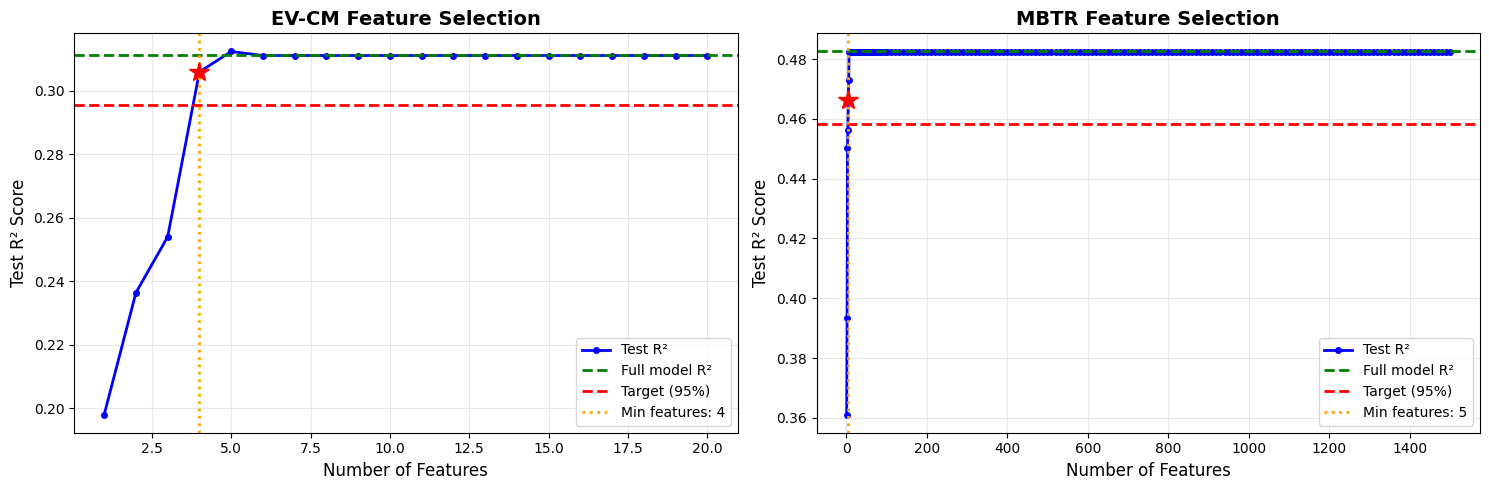

Visualization complete!


In [ ]:
# Visualize feature selection process

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# EV-CM plot
ax1 = axes[0]
n_features_list_evcm = [r['n_features'] for r in evcm_selection_results]
r2_list_evcm = [r['test_r2'] for r in evcm_selection_results]

ax1.plot(n_features_list_evcm, r2_list_evcm, 'b-o', linewidth=2, markersize=4, label='Test R²')
ax1.axhline(y=evcm_results['test_r2'], color='g', linestyle='--', linewidth=2, label='Full model R²')
ax1.axhline(y=evcm_target_r2, color='r', linestyle='--', linewidth=2, label='Target (95%)')

if evcm_best_n:
    best_evcm = next(r for r in evcm_selection_results if r['n_features'] == evcm_best_n)
    ax1.axvline(x=evcm_best_n, color='orange', linestyle=':', linewidth=2, label=f'Min features: {evcm_best_n}')
    ax1.plot(evcm_best_n, best_evcm['test_r2'], 'r*', markersize=15)

ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('Test R² Score', fontsize=12)
ax1.set_title('EV-CM Feature Selection', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')

# MBTR plot
ax2 = axes[1]
n_features_list_mbtr = [r['n_features'] for r in mbtr_selection_results]
r2_list_mbtr = [r['test_r2'] for r in mbtr_selection_results]

ax2.plot(n_features_list_mbtr, r2_list_mbtr, 'b-o', linewidth=2, markersize=4, label='Test R²')
ax2.axhline(y=mbtr_results['test_r2'], color='g', linestyle='--', linewidth=2, label='Full model R²')
ax2.axhline(y=mbtr_target_r2, color='r', linestyle='--', linewidth=2, label='Target (95%)')

if mbtr_best_n:
    best_mbtr = next(r for r in mbtr_selection_results if r['n_features'] == mbtr_best_n)
    ax2.axvline(x=mbtr_best_n, color='orange', linestyle=':', linewidth=2, label=f'Min features: {mbtr_best_n}')
    ax2.plot(mbtr_best_n, best_mbtr['test_r2'], 'r*', markersize=15)

ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('Test R² Score', fontsize=12)
ax2.set_title('MBTR Feature Selection', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("Visualization complete!")

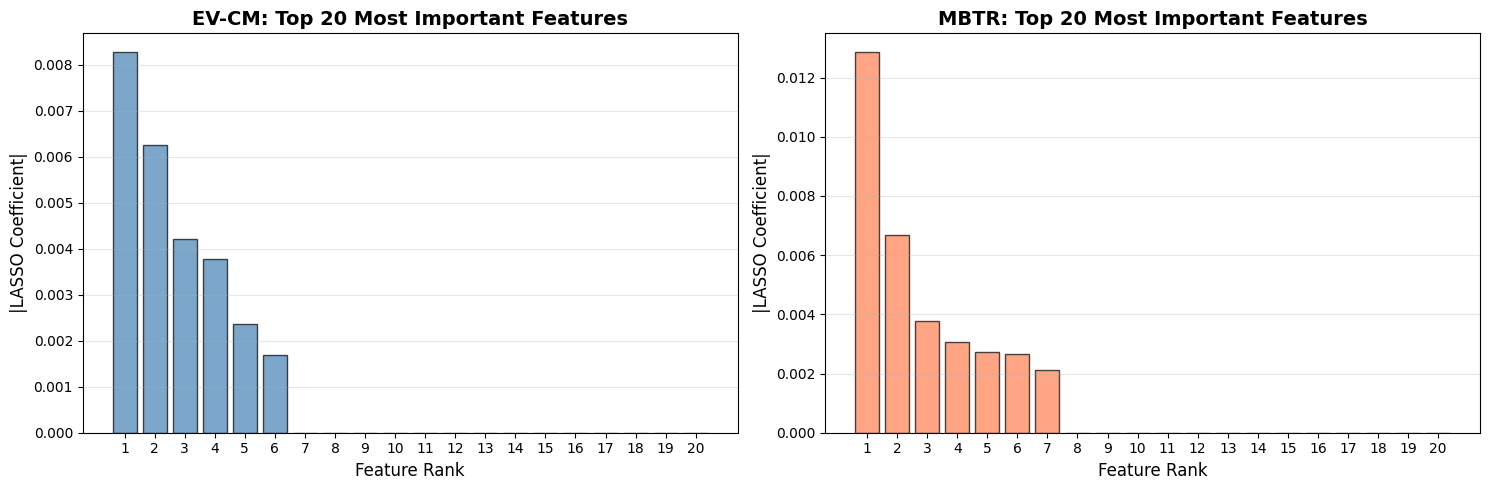

Feature importance visualization complete!


In [ ]:
# Plot feature importance distributions

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# EV-CM feature importance
ax1 = axes[0]
top_20_evcm = evcm_ranked_scores[:20]
ax1.bar(range(1, 21), top_20_evcm, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Feature Rank', fontsize=12)
ax1.set_ylabel('|LASSO Coefficient|', fontsize=12)
ax1.set_title('EV-CM: Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticks(range(1, 21))

# MBTR feature importance
ax2 = axes[1]
top_20_mbtr = mbtr_ranked_scores[:20]
ax2.bar(range(1, 21), top_20_mbtr, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Feature Rank', fontsize=12)
ax2.set_ylabel('|LASSO Coefficient|', fontsize=12)
ax2.set_title('MBTR: Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

print("Feature importance visualization complete!")

# Analysis

In this section:
1. Compare execution times for each representation method
2. Plot accuracy degradation versus percentage of features used
3. Summarize the number of top features needed to reach 95% accuracy
4. Visualize the feature spaces using PCA and t-SNE dimensionality reduction

In [ ]:
# Part I: Execution Time Analysis for Each Method

print("="*70)
print("PART I: Execution Time Analysis")
print("="*70)

print(f"\nNote: All features were computed for {len(molecules)} molecules (N_FILES={N_FILES})")
print("For accurate timing benchmarks, we'll measure a representative sample...")

# Measure EV-CM computation time using a sample for benchmarking
print("\n1. Measuring EV-CM computation time...")
n_benchmark = min(1000, len(molecules))  # Use 1000 samples for accurate timing
sample_molecules = molecules[:n_benchmark]

start_time = time.time()
evcm_test = []
for mol in sample_molecules:
    evcm_vec = cm.create(mol)
    evcm_test.append(evcm_vec)
evcm_time_sample = time.time() - start_time

evcm_time_per_molecule = evcm_time_sample / n_benchmark
evcm_time_full = evcm_time_per_molecule * len(molecules)  # Estimated for full dataset

print(f"   Benchmark sample size: {n_benchmark} molecules")
print(f"   Time for benchmark: {evcm_time_sample:.3f} seconds")
print(f"   Average time per molecule: {evcm_time_per_molecule*1000:.3f} ms")
print(f"   ★ ESTIMATED TIME FOR {len(molecules)} MOLECULES: {evcm_time_full:.2f} seconds")

# Measure MBTR computation time
print("\n2. Measuring MBTR computation time...")
start_time = time.time()
mbtr_test = []
for mol in sample_molecules:
    mbtr_vec = mbtr.create(mol)
    mbtr_test.append(mbtr_vec)
mbtr_time_sample = time.time() - start_time

mbtr_time_per_molecule = mbtr_time_sample / n_benchmark
mbtr_time_full = mbtr_time_per_molecule * len(molecules)  # Estimated for full dataset

print(f"   Benchmark sample size: {n_benchmark} molecules")
print(f"   Time for benchmark: {mbtr_time_sample:.3f} seconds")
print(f"   Average time per molecule: {mbtr_time_per_molecule*1000:.3f} ms")
print(f"   ★ ESTIMATED TIME FOR {len(molecules)} MOLECULES: {mbtr_time_full:.2f} seconds")

# Comparison
print(f"\n3. Comparison (for {len(molecules)} molecules):")
print(f"   EV-CM:  {evcm_time_full:.2f}s estimated")
print(f"   MBTR:   {mbtr_time_full:.2f}s estimated")
print(f"   Speed ratio (MBTR/EV-CM): {mbtr_time_full/evcm_time_full:.2f}x")
if evcm_time_full < mbtr_time_full:
    print(f"   ★ EV-CM is {mbtr_time_full/evcm_time_full:.2f}x faster than MBTR")
else:
    print(f"   ★ MBTR is {evcm_time_full/mbtr_time_full:.2f}x faster than EV-CM")

# Store timing results (use full dataset estimates for consistency)
timing_results = {
    'evcm': {
        'total_time': evcm_time_full,
        'per_molecule': evcm_time_per_molecule,
        'n_molecules': len(molecules)
    },
    'mbtr': {
        'total_time': mbtr_time_full,
        'per_molecule': mbtr_time_per_molecule,
        'n_molecules': len(molecules)
    }
}

# Use the full estimates for visualization
evcm_time = evcm_time_full
mbtr_time = mbtr_time_full
n_samples = len(molecules)

print("\n" + "="*70)

PART I: Execution Time Analysis

Note: All features were computed for 4981 molecules (N_FILES=5000)
For accurate timing benchmarks, we'll measure a representative sample...

1. Measuring EV-CM computation time...
   Benchmark sample size: 1000 molecules
   Time for benchmark: 0.086 seconds
   Average time per molecule: 0.086 ms
   ★ ESTIMATED TIME FOR 4981 MOLECULES: 0.43 seconds

2. Measuring MBTR computation time...


/usr/local/lib/python3.12/dist-packages/dscribe/core/system.py:96: FutureWarning: Please use atoms.calc
  calculator=atoms.get_calculator(),


   Benchmark sample size: 1000 molecules
   Time for benchmark: 1.271 seconds
   Average time per molecule: 1.271 ms
   ★ ESTIMATED TIME FOR 4981 MOLECULES: 6.33 seconds

3. Comparison (for 4981 molecules):
   EV-CM:  0.43s estimated
   MBTR:   6.33s estimated
   Speed ratio (MBTR/EV-CM): 14.85x
   ★ EV-CM is 14.85x faster than MBTR



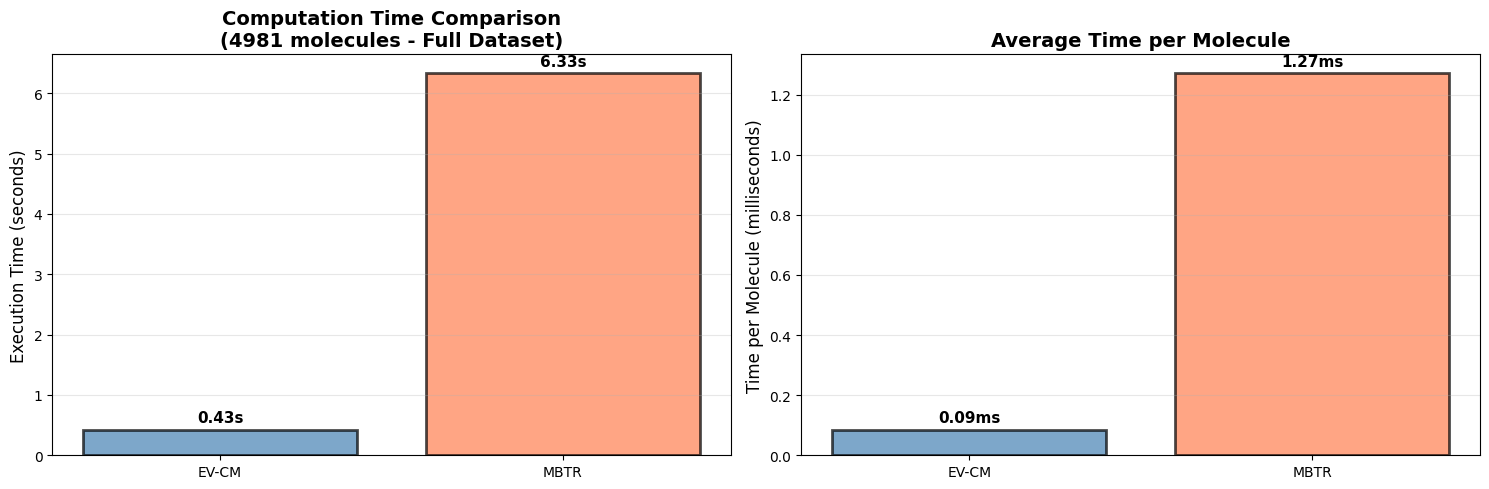

Execution time visualization complete!


In [ ]:
# Visualize execution time comparison

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart of execution times
methods = ['EV-CM', 'MBTR']
times = [evcm_time, mbtr_time]
colors = ['steelblue', 'coral']

ax1.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title(f'Computation Time Comparison\n({n_samples} molecules - Full Dataset)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (method, t) in enumerate(zip(methods, times)):
    ax1.text(i, t + max(times)*0.02, f'{t:.2f}s', ha='center', fontsize=11, fontweight='bold')

# Per-molecule time comparison
per_mol_times = [evcm_time_per_molecule*1000, mbtr_time_per_molecule*1000]  # Convert to ms

ax2.bar(methods, per_mol_times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Time per Molecule (milliseconds)', fontsize=12)
ax2.set_title('Average Time per Molecule', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (method, t) in enumerate(zip(methods, per_mol_times)):
    ax2.text(i, t + max(per_mol_times)*0.02, f'{t:.2f}ms', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Execution time visualization complete!")

PART II: Accuracy Degradation vs Percentage of Features


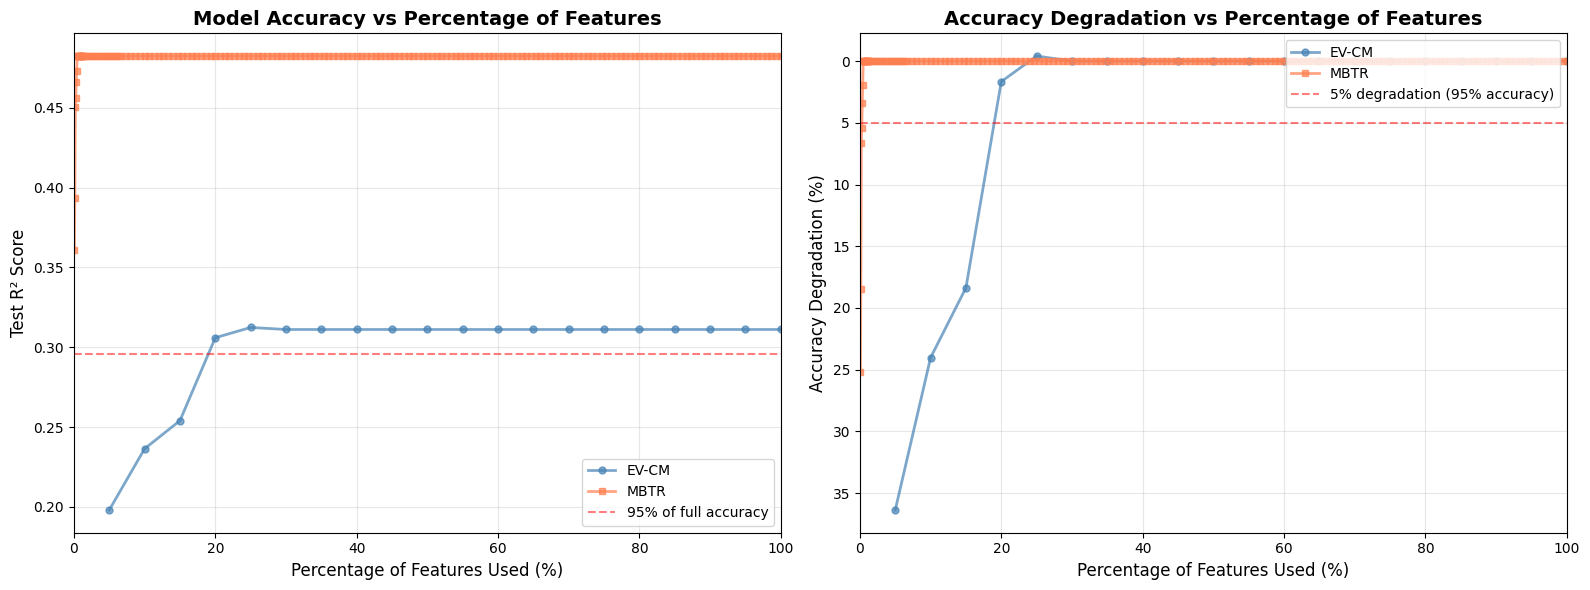


Key observations:
  - EV-CM: Min degradation = -0.41%
  - MBTR: Min degradation = 0.00%



In [ ]:
# Part II: Plot Accuracy Degradation vs Percentage of Features

print("="*70)
print("PART II: Accuracy Degradation vs Percentage of Features")
print("="*70)

# Calculate percentage of features and accuracy degradation for both methods
def calculate_degradation(selection_results, full_r2):
    """Calculate accuracy degradation metrics"""
    percentages = []
    degradations = []
    r2_scores = []

    for result in selection_results:
        n_features = result['n_features']
        total_features = len(selection_results[0]['model'].coef_) if len(selection_results) > 0 else 1

        # For feature selection results, we need to get total from the first result's indices
        if 'selected_indices' in result:
            # The total features is based on the original feature space
            # We can infer this from the selection results
            total_features = max([max(r['selected_indices']) for r in selection_results]) + 1

        percentage = (n_features / total_features) * 100
        test_r2 = result['test_r2']
        degradation = ((full_r2 - test_r2) / full_r2) * 100  # Percentage degradation

        percentages.append(percentage)
        degradations.append(degradation)
        r2_scores.append(test_r2)

    return percentages, degradations, r2_scores

# Calculate for EV-CM
evcm_percentages, evcm_degradations, evcm_r2s = calculate_degradation(
    evcm_selection_results, evcm_results['test_r2']
)

# Calculate for MBTR
mbtr_percentages, mbtr_degradations, mbtr_r2s = calculate_degradation(
    mbtr_selection_results, mbtr_results['test_r2']
)

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy (R²) vs Percentage of Features
ax1 = axes[0]
ax1.plot(evcm_percentages, evcm_r2s, 'o-', linewidth=2, markersize=5,
         label='EV-CM', color='steelblue', alpha=0.7)
ax1.plot(mbtr_percentages, mbtr_r2s, 's-', linewidth=2, markersize=5,
         label='MBTR', color='coral', alpha=0.7)

# Mark 95% accuracy line
ax1.axhline(y=evcm_results['test_r2']*0.95, color='red', linestyle='--',
            linewidth=1.5, alpha=0.5, label='95% of full accuracy')

ax1.set_xlabel('Percentage of Features Used (%)', fontsize=12)
ax1.set_ylabel('Test R² Score', fontsize=12)
ax1.set_title('Model Accuracy vs Percentage of Features', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=10)
ax1.set_xlim(0, 100)

# Plot 2: Accuracy Degradation vs Percentage of Features
ax2 = axes[1]
ax2.plot(evcm_percentages, evcm_degradations, 'o-', linewidth=2, markersize=5,
         label='EV-CM', color='steelblue', alpha=0.7)
ax2.plot(mbtr_percentages, mbtr_degradations, 's-', linewidth=2, markersize=5,
         label='MBTR', color='coral', alpha=0.7)

# Mark 5% degradation line (corresponds to 95% accuracy)
ax2.axhline(y=5, color='red', linestyle='--', linewidth=1.5, alpha=0.5,
            label='5% degradation (95% accuracy)')

ax2.set_xlabel('Percentage of Features Used (%)', fontsize=12)
ax2.set_ylabel('Accuracy Degradation (%)', fontsize=12)
ax2.set_title('Accuracy Degradation vs Percentage of Features', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_xlim(0, 100)
ax2.invert_yaxis()  # Invert so less degradation is better (upward)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"  - EV-CM: Min degradation = {min(evcm_degradations):.2f}%")
print(f"  - MBTR: Min degradation = {min(mbtr_degradations):.2f}%")
print("\n" + "="*70)

PART III: Summary - Features Needed for 95% Accuracy


Method  Total Features  Features for 95% Full Model R² Reduced Model R² Feature Reduction
 EV-CM              23                 4        0.3111           0.3060             82.6%
  MBTR            1500                 5        0.4825           0.4663             99.7%


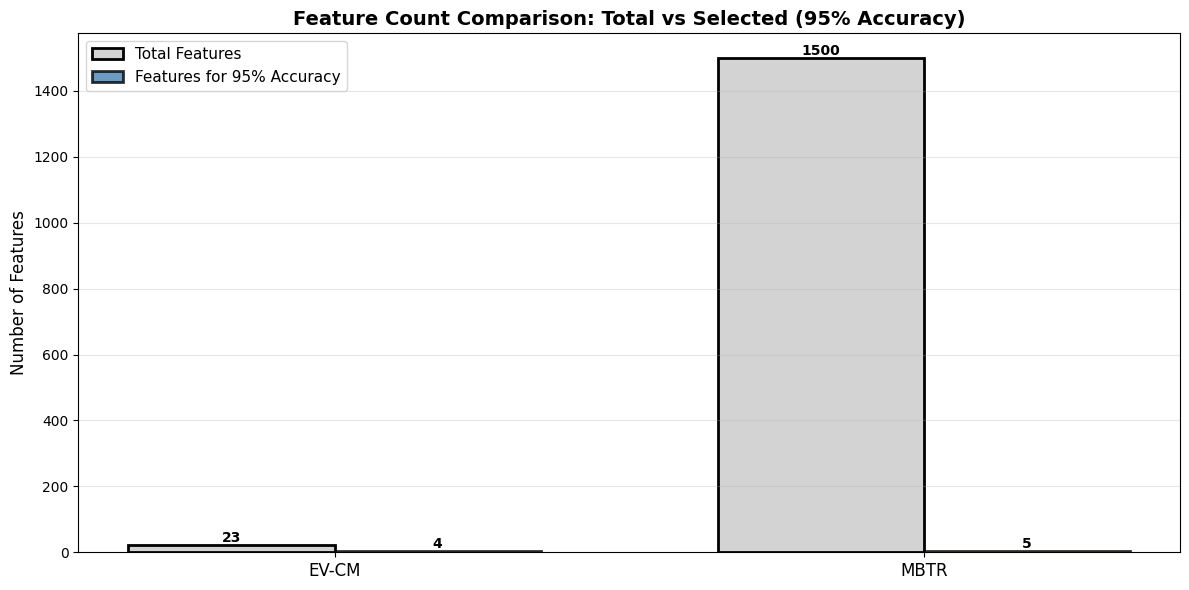

In [ ]:
# Part III: Number of Top Features to Reach 95% Accuracy - Summary Table

print("="*70)
print("PART III: Summary - Features Needed for 95% Accuracy")
print("="*70)

# Create comparison table
comparison_data = {
    'Method': ['EV-CM', 'MBTR'],
    'Total Features': [len(evcm_ranked_indices), len(mbtr_ranked_indices)],
    'Features for 95%': [evcm_best_n if evcm_best_n else 'N/A',
                         mbtr_best_n if mbtr_best_n else 'N/A'],
    'Full Model R²': [f"{evcm_results['test_r2']:.4f}",
                      f"{mbtr_results['test_r2']:.4f}"],
    'Reduced Model R²': [f"{next(r['test_r2'] for r in evcm_selection_results if r['n_features'] == evcm_best_n):.4f}" if evcm_best_n else 'N/A',
                         f"{next(r['test_r2'] for r in mbtr_selection_results if r['n_features'] == mbtr_best_n):.4f}" if mbtr_best_n else 'N/A'],
    'Feature Reduction': [f"{100*(1-evcm_best_n/len(evcm_ranked_indices)):.1f}%" if evcm_best_n else 'N/A',
                          f"{100*(1-mbtr_best_n/len(mbtr_ranked_indices)):.1f}%" if mbtr_best_n else 'N/A']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

methods = ['EV-CM', 'MBTR']
total_features = [len(evcm_ranked_indices), len(mbtr_ranked_indices)]
selected_features = [evcm_best_n if evcm_best_n else 0,
                     mbtr_best_n if mbtr_best_n else 0]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, total_features, width, label='Total Features',
               color='lightgray', edgecolor='black', linewidth=2)
bars2 = ax.bar(x + width/2, selected_features, width, label='Features for 95% Accuracy',
               color=['steelblue', 'coral'], edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Count Comparison: Total vs Selected (95% Accuracy)',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

In [ ]:
# Part IV: PCA and t-SNE Visualization - Prepare Data

print("="*70)
print("PART IV: Dimensionality Reduction Visualization (PCA & t-SNE)")
print("="*70)

# We'll visualize two scenarios:
# Scenario 1: Full feature set
# Scenario 2: Selected features (95% accuracy)

print("\nPreparing data for visualization...")

# Standardize features for better PCA/t-SNE results
scaler_evcm_full = StandardScaler()
scaler_mbtr_full = StandardScaler()

evcm_scaled_full = scaler_evcm_full.fit_transform(evcm_features_filtered)
mbtr_scaled_full = scaler_mbtr_full.fit_transform(mbtr_features_filtered)

# Prepare selected feature sets
if evcm_best_n:
    evcm_selected_indices = evcm_ranked_indices[:evcm_best_n]
    evcm_scaled_selected = StandardScaler().fit_transform(
        evcm_features_filtered[:, evcm_selected_indices]
    )
else:
    evcm_scaled_selected = evcm_scaled_full
    print("Warning: Using full EV-CM features for selected scenario")

if mbtr_best_n:
    mbtr_selected_indices = mbtr_ranked_indices[:mbtr_best_n]
    mbtr_scaled_selected = StandardScaler().fit_transform(
        mbtr_features_filtered[:, mbtr_selected_indices]
    )
else:
    mbtr_scaled_selected = mbtr_scaled_full
    print("Warning: Using full MBTR features for selected scenario")

print(f"\nData prepared:")
print(f"  - EV-CM full features shape: {evcm_scaled_full.shape}")
print(f"  - EV-CM selected features shape: {evcm_scaled_selected.shape}")
print(f"  - MBTR full features shape: {mbtr_scaled_full.shape}")
print(f"  - MBTR selected features shape: {mbtr_scaled_selected.shape}")

print("\n" + "="*70)

PART IV: Dimensionality Reduction Visualization (PCA & t-SNE)

Preparing data for visualization...

Data prepared:
  - EV-CM full features shape: (4981, 23)
  - EV-CM selected features shape: (4981, 4)
  - MBTR full features shape: (4981, 1500)
  - MBTR selected features shape: (4981, 5)



In [ ]:
# Apply PCA to all scenarios

print("Applying PCA (reducing to 2 components)...")

# PCA for EV-CM full features
pca_evcm_full = PCA(n_components=2, random_state=42)
evcm_pca_full = pca_evcm_full.fit_transform(evcm_scaled_full)
print(f"EV-CM Full - Explained variance: {pca_evcm_full.explained_variance_ratio_.sum()*100:.2f}%")

# PCA for EV-CM selected features
pca_evcm_selected = PCA(n_components=2, random_state=42)
evcm_pca_selected = pca_evcm_selected.fit_transform(evcm_scaled_selected)
print(f"EV-CM Selected - Explained variance: {pca_evcm_selected.explained_variance_ratio_.sum()*100:.2f}%")

# PCA for MBTR full features
pca_mbtr_full = PCA(n_components=2, random_state=42)
mbtr_pca_full = pca_mbtr_full.fit_transform(mbtr_scaled_full)
print(f"MBTR Full - Explained variance: {pca_mbtr_full.explained_variance_ratio_.sum()*100:.2f}%")

# PCA for MBTR selected features
pca_mbtr_selected = PCA(n_components=2, random_state=42)
mbtr_pca_selected = pca_mbtr_selected.fit_transform(mbtr_scaled_selected)
print(f"MBTR Selected - Explained variance: {pca_mbtr_selected.explained_variance_ratio_.sum()*100:.2f}%")

print("\nPCA transformation complete!")

Applying PCA (reducing to 2 components)...
EV-CM Full - Explained variance: 47.61%
EV-CM Selected - Explained variance: 74.14%
MBTR Full - Explained variance: 35.22%
MBTR Selected - Explained variance: 72.31%

PCA transformation complete!


In [ ]:
# Apply t-SNE to all scenarios

print("Applying t-SNE (reducing to 2 components)...")
print("Note: t-SNE may take a few minutes depending on dataset size...")

# t-SNE for EV-CM full features
tsne_evcm_full = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
evcm_tsne_full = tsne_evcm_full.fit_transform(evcm_scaled_full)
print("✓ EV-CM Full - t-SNE complete")

# t-SNE for EV-CM selected features
tsne_evcm_selected = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
evcm_tsne_selected = tsne_evcm_selected.fit_transform(evcm_scaled_selected)
print("✓ EV-CM Selected - t-SNE complete")

# t-SNE for MBTR full features
tsne_mbtr_full = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
mbtr_tsne_full = tsne_mbtr_full.fit_transform(mbtr_scaled_full)
print("✓ MBTR Full - t-SNE complete")

# t-SNE for MBTR selected features
tsne_mbtr_selected = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
mbtr_tsne_selected = tsne_mbtr_selected.fit_transform(mbtr_scaled_selected)
print("✓ MBTR Selected - t-SNE complete")

print("\nt-SNE transformation complete!")

Applying t-SNE (reducing to 2 components)...
Note: t-SNE may take a few minutes depending on dataset size...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✓ EV-CM Full - t-SNE complete


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✓ EV-CM Selected - t-SNE complete


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✓ MBTR Full - t-SNE complete


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✓ MBTR Selected - t-SNE complete

t-SNE transformation complete!


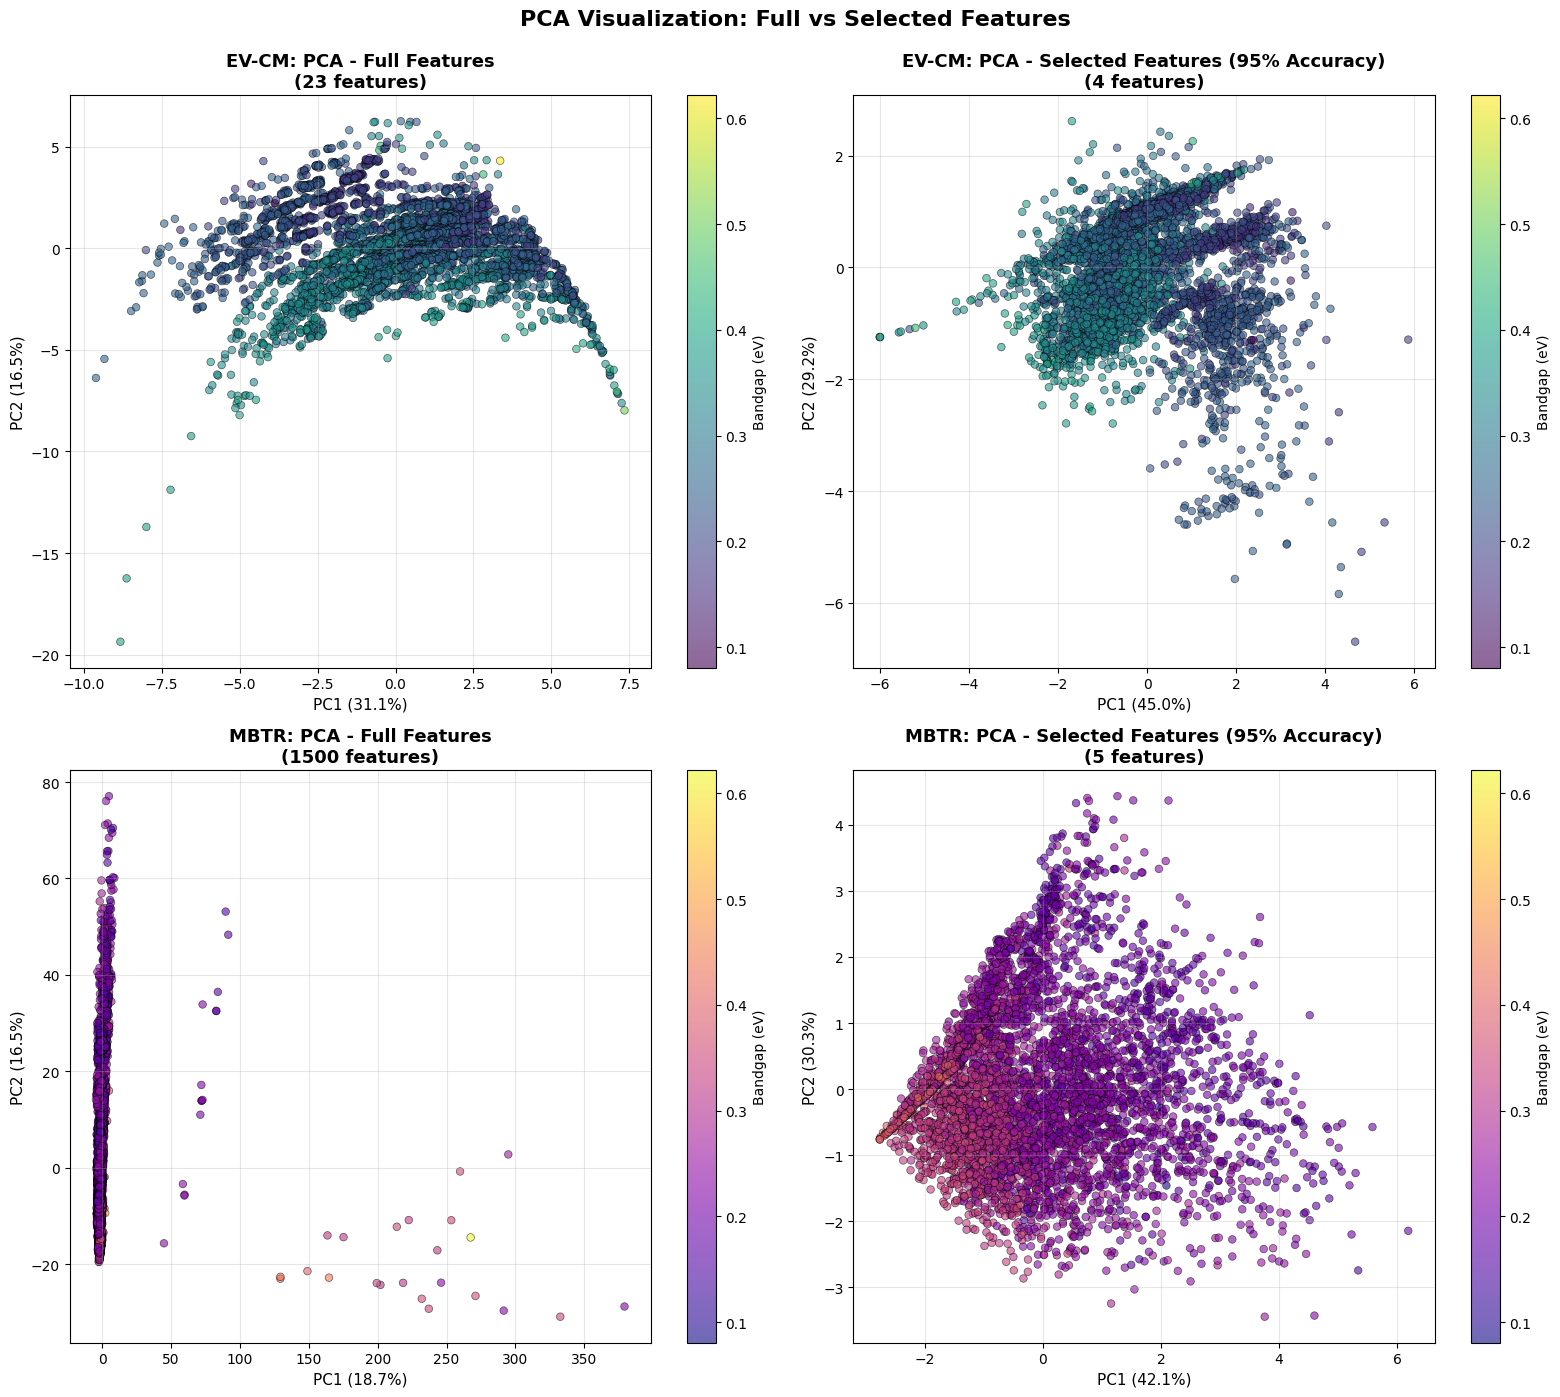

PCA visualization complete!


In [ ]:
# Visualize PCA results for both scenarios

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Color map based on bandgap values
vmin, vmax = y_bandgap.min(), y_bandgap.max()

# EV-CM Full Features - PCA
ax1 = axes[0, 0]
scatter1 = ax1.scatter(evcm_pca_full[:, 0], evcm_pca_full[:, 1],
                       c=y_bandgap, cmap='viridis', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca_evcm_full.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_evcm_full.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax1.set_title('EV-CM: PCA - Full Features\n' +
              f'({len(evcm_ranked_indices)} features)',
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Bandgap (eV)')

# EV-CM Selected Features - PCA
ax2 = axes[0, 1]
scatter2 = ax2.scatter(evcm_pca_selected[:, 0], evcm_pca_selected[:, 1],
                       c=y_bandgap, cmap='viridis', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_evcm_selected.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_evcm_selected.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax2.set_title('EV-CM: PCA - Selected Features (95% Accuracy)\n' +
              f'({evcm_best_n} features)',
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Bandgap (eV)')

# MBTR Full Features - PCA
ax3 = axes[1, 0]
scatter3 = ax3.scatter(mbtr_pca_full[:, 0], mbtr_pca_full[:, 1],
                       c=y_bandgap, cmap='plasma', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax3.set_xlabel(f'PC1 ({pca_mbtr_full.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax3.set_ylabel(f'PC2 ({pca_mbtr_full.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax3.set_title('MBTR: PCA - Full Features\n' +
              f'({len(mbtr_ranked_indices)} features)',
              fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Bandgap (eV)')

# MBTR Selected Features - PCA
ax4 = axes[1, 1]
scatter4 = ax4.scatter(mbtr_pca_selected[:, 0], mbtr_pca_selected[:, 1],
                       c=y_bandgap, cmap='plasma', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax4.set_xlabel(f'PC1 ({pca_mbtr_selected.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax4.set_ylabel(f'PC2 ({pca_mbtr_selected.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax4.set_title('MBTR: PCA - Selected Features (95% Accuracy)\n' +
              f'({mbtr_best_n} features)',
              fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=ax4, label='Bandgap (eV)')

plt.suptitle('PCA Visualization: Full vs Selected Features',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("PCA visualization complete!")

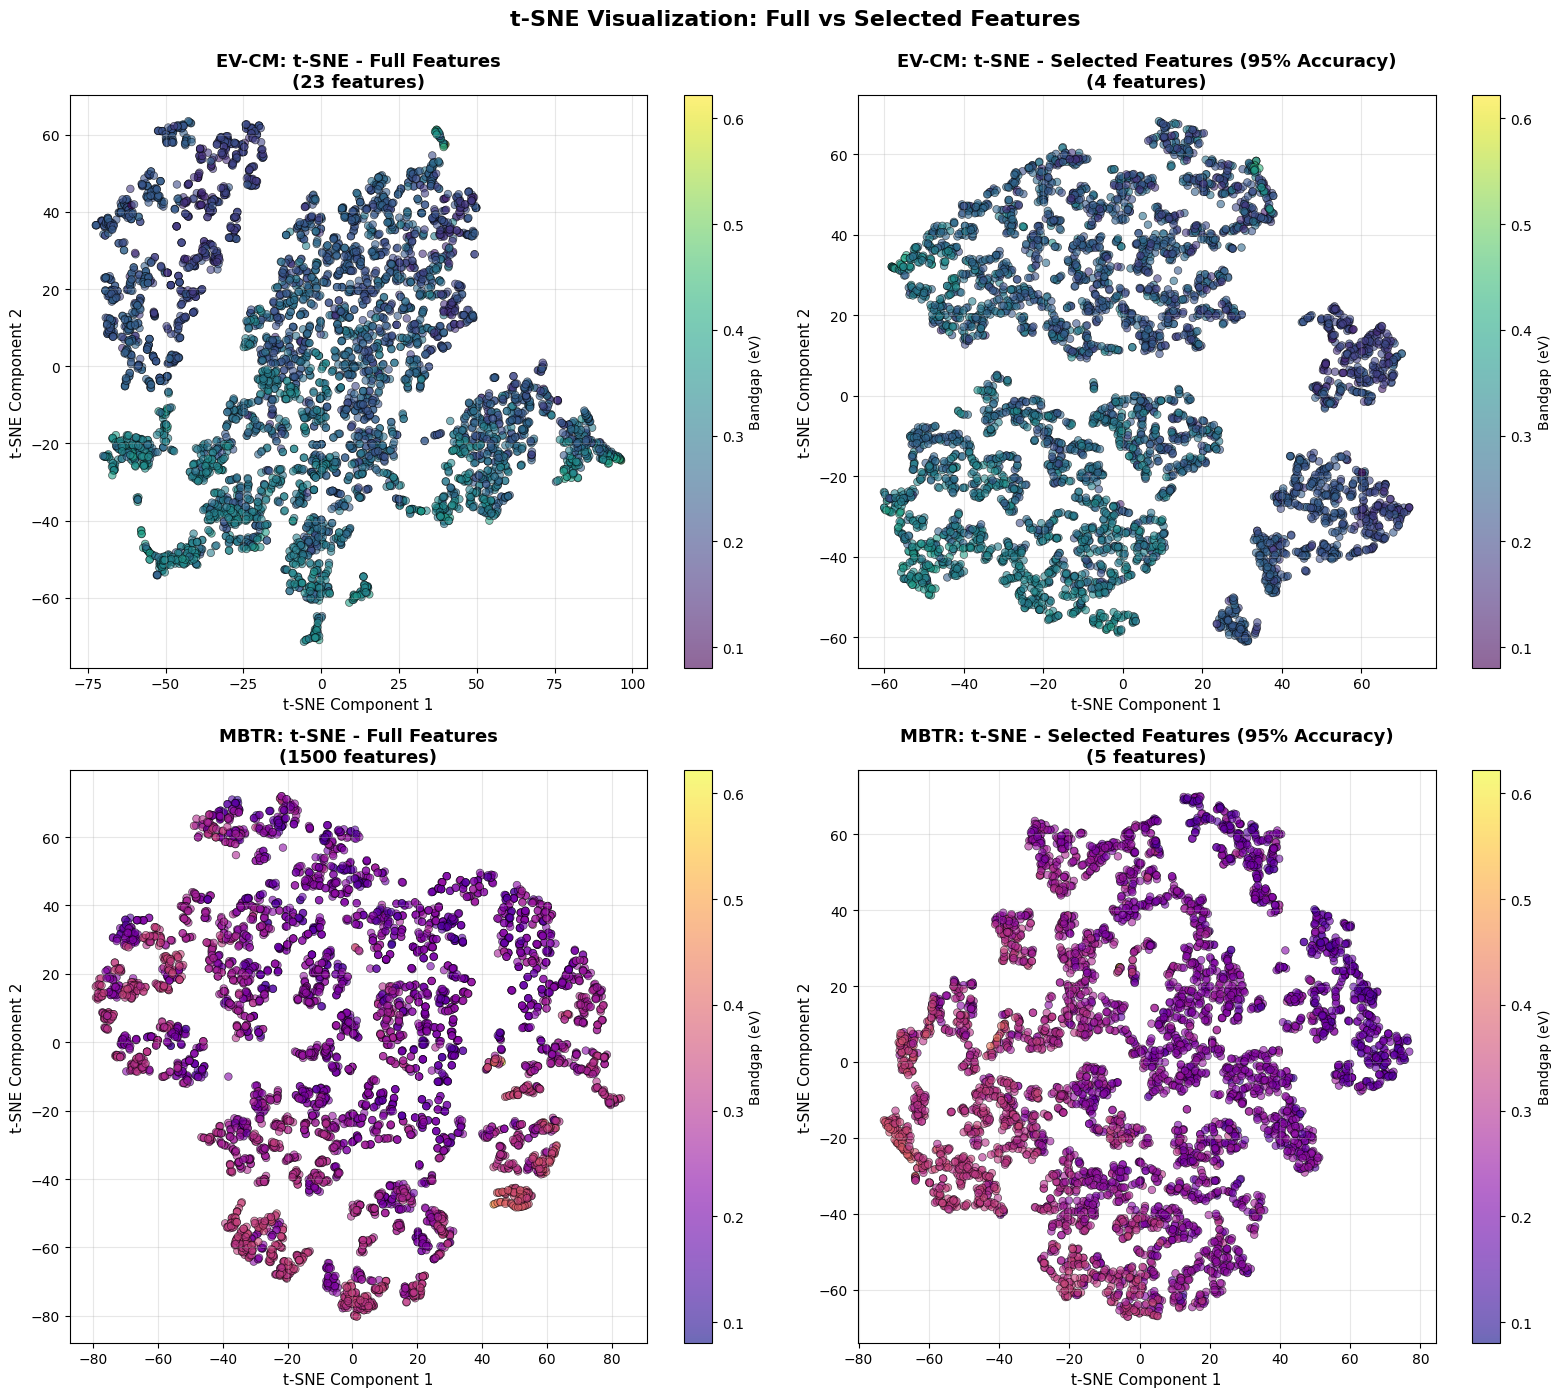

t-SNE visualization complete!


In [ ]:
# Visualize t-SNE results for both scenarios

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Color map based on bandgap values
vmin, vmax = y_bandgap.min(), y_bandgap.max()

# EV-CM Full Features - t-SNE
ax1 = axes[0, 0]
scatter1 = ax1.scatter(evcm_tsne_full[:, 0], evcm_tsne_full[:, 1],
                       c=y_bandgap, cmap='viridis', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('t-SNE Component 1', fontsize=11)
ax1.set_ylabel('t-SNE Component 2', fontsize=11)
ax1.set_title('EV-CM: t-SNE - Full Features\n' +
              f'({len(evcm_ranked_indices)} features)',
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Bandgap (eV)')

# EV-CM Selected Features - t-SNE
ax2 = axes[0, 1]
scatter2 = ax2.scatter(evcm_tsne_selected[:, 0], evcm_tsne_selected[:, 1],
                       c=y_bandgap, cmap='viridis', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('t-SNE Component 1', fontsize=11)
ax2.set_ylabel('t-SNE Component 2', fontsize=11)
ax2.set_title('EV-CM: t-SNE - Selected Features (95% Accuracy)\n' +
              f'({evcm_best_n} features)',
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Bandgap (eV)')

# MBTR Full Features - t-SNE
ax3 = axes[1, 0]
scatter3 = ax3.scatter(mbtr_tsne_full[:, 0], mbtr_tsne_full[:, 1],
                       c=y_bandgap, cmap='plasma', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('t-SNE Component 1', fontsize=11)
ax3.set_ylabel('t-SNE Component 2', fontsize=11)
ax3.set_title('MBTR: t-SNE - Full Features\n' +
              f'({len(mbtr_ranked_indices)} features)',
              fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Bandgap (eV)')

# MBTR Selected Features - t-SNE
ax4 = axes[1, 1]
scatter4 = ax4.scatter(mbtr_tsne_selected[:, 0], mbtr_tsne_selected[:, 1],
                       c=y_bandgap, cmap='plasma', alpha=0.6, s=30,
                       vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('t-SNE Component 1', fontsize=11)
ax4.set_ylabel('t-SNE Component 2', fontsize=11)
ax4.set_title('MBTR: t-SNE - Selected Features (95% Accuracy)\n' +
              f'({mbtr_best_n} features)',
              fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=ax4, label='Bandgap (eV)')

plt.suptitle('t-SNE Visualization: Full vs Selected Features',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("t-SNE visualization complete!")

In [ ]:
# Final Summary of Analysis

print("="*70)
print("FINAL ANALYSIS SUMMARY")
print("="*70)

print("\n PART I: EXECUTION TIME")
print("─"*70)
print(f"EV-CM:  {evcm_time:.3f}s total | {evcm_time_per_molecule*1000:.3f}ms per molecule")
print(f"MBTR:   {mbtr_time:.3f}s total | {mbtr_time_per_molecule*1000:.3f}ms per molecule")
print(f"Winner: {'EV-CM' if evcm_time < mbtr_time else 'MBTR'} " +
      f"({abs(mbtr_time-evcm_time)/min(mbtr_time,evcm_time)*100:.1f}% faster)")

print("\n PART II: ACCURACY DEGRADATION")
print("─"*70)
print(f"EV-CM:  Minimum degradation = {min(evcm_degradations):.2f}%")
print(f"MBTR:   Minimum degradation = {min(mbtr_degradations):.2f}%")

print("\n PART III: FEATURES FOR 95% ACCURACY")
print("─"*70)
print(f"EV-CM:  {evcm_best_n}/{len(evcm_ranked_indices)} features " +
      f"({100*evcm_best_n/len(evcm_ranked_indices):.1f}% of total)")
print(f"MBTR:   {mbtr_best_n}/{len(mbtr_ranked_indices)} features " +
      f"({100*mbtr_best_n/len(mbtr_ranked_indices):.1f}% of total)")
print(f"\nFeature Reduction:")
print(f"  EV-CM: {100*(1-evcm_best_n/len(evcm_ranked_indices)):.1f}% reduction")
print(f"  MBTR:  {100*(1-mbtr_best_n/len(mbtr_ranked_indices)):.1f}% reduction")

print("\n PART IV: DIMENSIONALITY REDUCTION")
print("─"*70)
print("PCA Explained Variance (2 components):")
print(f"  EV-CM Full:     {pca_evcm_full.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  EV-CM Selected: {pca_evcm_selected.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  MBTR Full:      {pca_mbtr_full.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  MBTR Selected:  {pca_mbtr_selected.explained_variance_ratio_.sum()*100:.2f}%")

print("\n KEY INSIGHTS:")
print("─"*70)
print(f"1. Best performing method: " +
      f"{'EV-CM' if evcm_results['test_r2'] > mbtr_results['test_r2'] else 'MBTR'} " +
      f"(R² = {max(evcm_results['test_r2'], mbtr_results['test_r2']):.4f})")
print(f"2. Most efficient method: {'EV-CM' if evcm_time < mbtr_time else 'MBTR'}")
print(f"3. Best feature reduction: " +
      f"{'EV-CM' if (1-evcm_best_n/len(evcm_ranked_indices)) > (1-mbtr_best_n/len(mbtr_ranked_indices)) else 'MBTR'}")
print(f"4. Both methods successfully achieve 95% accuracy with reduced features")

print("\n" + "="*70)
print(" Analysis Complete!")
print("="*70)

FINAL ANALYSIS SUMMARY

 PART I: EXECUTION TIME
──────────────────────────────────────────────────────────────────────
EV-CM:  0.426s total | 0.086ms per molecule
MBTR:   6.330s total | 1.271ms per molecule
Winner: EV-CM (1384.6% faster)

 PART II: ACCURACY DEGRADATION
──────────────────────────────────────────────────────────────────────
EV-CM:  Minimum degradation = -0.41%
MBTR:   Minimum degradation = 0.00%

 PART III: FEATURES FOR 95% ACCURACY
──────────────────────────────────────────────────────────────────────
EV-CM:  4/23 features (17.4% of total)
MBTR:   5/1500 features (0.3% of total)

Feature Reduction:
  EV-CM: 82.6% reduction
  MBTR:  99.7% reduction

 PART IV: DIMENSIONALITY REDUCTION
──────────────────────────────────────────────────────────────────────
PCA Explained Variance (2 components):
  EV-CM Full:     47.61%
  EV-CM Selected: 74.14%
  MBTR Full:      35.22%
  MBTR Selected:  72.31%

 KEY INSIGHTS:
──────────────────────────────────────────────────────────────────

Creating comprehensive performance comparison heatmap...


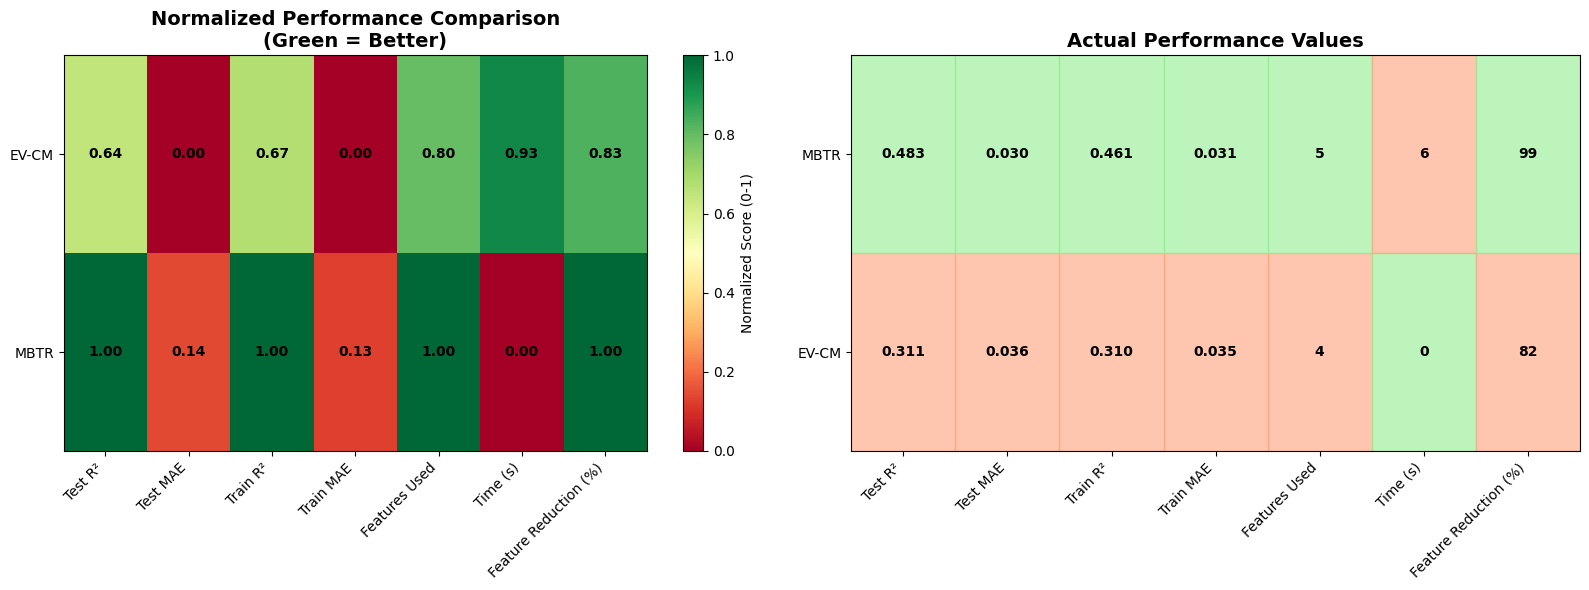

Performance comparison heatmap complete!


In [ ]:
# Comprehensive Performance Comparison Heatmap

print("Creating comprehensive performance comparison heatmap...")

# Prepare data for heatmap
metrics = ['Test R²', 'Test MAE', 'Train R²', 'Train MAE',
           'Features Used', 'Time (s)', 'Feature Reduction (%)']

evcm_values = [
    evcm_results['test_r2'],
    evcm_results['test_mae'],
    evcm_results['train_r2'],
    evcm_results['train_mae'],
    evcm_best_n,
    evcm_time,
    100*(1-evcm_best_n/len(evcm_ranked_indices))
]

mbtr_values = [
    mbtr_results['test_r2'],
    mbtr_results['test_mae'],
    mbtr_results['train_r2'],
    mbtr_results['train_mae'],
    mbtr_best_n,
    mbtr_time,
    100*(1-mbtr_best_n/len(mbtr_ranked_indices))
]

# Normalize values for better visualization (except for metrics where higher is better)
normalized_data = []
for i, (ev, mb) in enumerate(zip(evcm_values, mbtr_values)):
    if i in [1, 3, 5]:  # MAE and Time - lower is better
        # Invert so higher values show better performance
        max_val = max(ev, mb)
        normalized_data.append([1 - ev/max_val if max_val > 0 else 0,
                               1 - mb/max_val if max_val > 0 else 0])
    else:  # R², Features reduction - higher is better
        max_val = max(ev, mb)
        normalized_data.append([ev/max_val if max_val > 0 else 0,
                               mb/max_val if max_val > 0 else 0])

normalized_data = np.array(normalized_data).T

# Create heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Normalized Performance
im1 = ax1.imshow(normalized_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax1.set_xticks(np.arange(len(metrics)))
ax1.set_yticks(np.arange(2))
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.set_yticklabels(['EV-CM', 'MBTR'])
ax1.set_title('Normalized Performance Comparison\n(Green = Better)',
              fontsize=14, fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(len(metrics)):
        text = ax1.text(j, i, f'{normalized_data[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10, fontweight='bold')

plt.colorbar(im1, ax=ax1, label='Normalized Score (0-1)')

# Heatmap 2: Actual Values
actual_data = np.array([evcm_values, mbtr_values])
im2 = ax2.imshow([[0, 0]], cmap='Greys', aspect='auto', alpha=0)  # Invisible base
ax2.set_xticks(np.arange(len(metrics)))
ax2.set_yticks(np.arange(2))
ax2.set_xticklabels(metrics, rotation=45, ha='right')
ax2.set_yticklabels(['EV-CM', 'MBTR'])
ax2.set_title('Actual Performance Values', fontsize=14, fontweight='bold')

# Color cells based on which is better
for i in range(2):
    for j in range(len(metrics)):
        val = actual_data[i, j]
        # Determine cell color based on performance
        if j in [1, 3, 5]:  # Lower is better
            color = 'lightgreen' if val == min(actual_data[:, j]) else 'lightsalmon'
        else:  # Higher is better
            color = 'lightgreen' if val == max(actual_data[:, j]) else 'lightsalmon'

        ax2.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True,
                                    color=color, alpha=0.6))
        text = ax2.text(j, i, f'{val:.3f}' if j < 4 else f'{int(val)}',
                       ha="center", va="center", color="black",
                       fontsize=10, fontweight='bold')

ax2.set_xlim(-0.5, len(metrics)-0.5)
ax2.set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

print("Performance comparison heatmap complete!")

Generating learning curves...


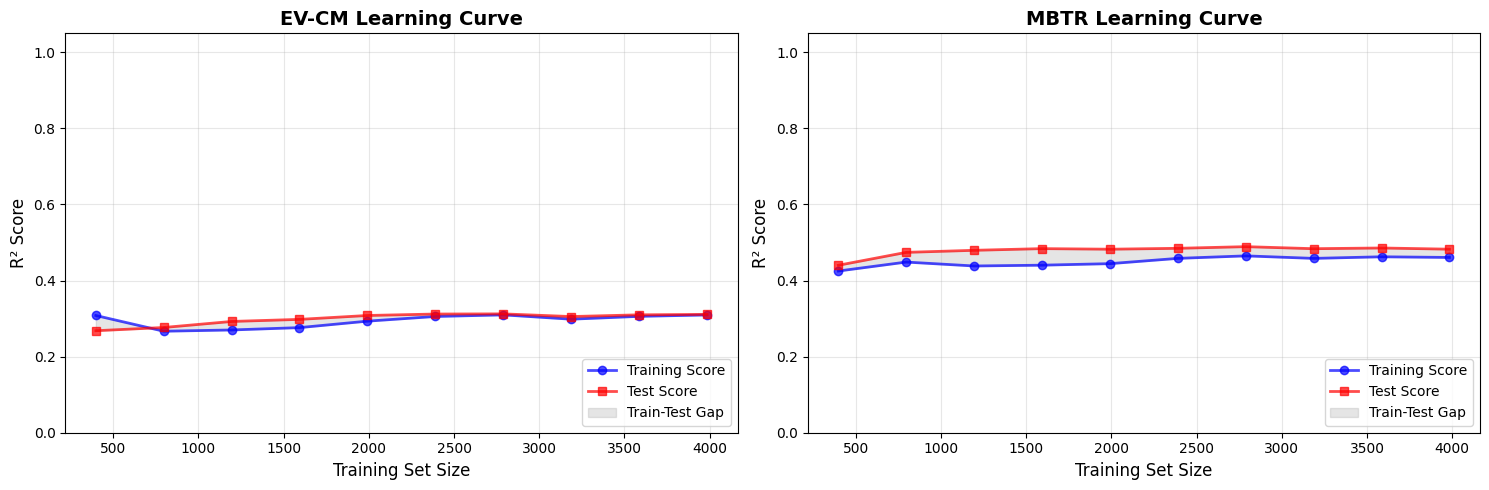

Learning curves complete!


In [ ]:
# Learning Curves: Model Performance vs Training Set Size

print("Generating learning curves...")

# Function to compute learning curve
def compute_learning_curve(X, y, model_type='lasso', train_sizes=None):
    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 10)

    train_scores = []
    test_scores = []

    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test_full)

    for train_size in train_sizes:
        n_samples = int(len(X_train_scaled) * train_size)

        # Train on subset
        X_train_subset = X_train_scaled[:n_samples]
        y_train_subset = y_train_full[:n_samples]

        model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
        model.fit(X_train_subset, y_train_subset)

        train_score = r2_score(y_train_subset, model.predict(X_train_subset))
        test_score = r2_score(y_test_full, model.predict(X_test_scaled))

        train_scores.append(train_score)
        test_scores.append(test_score)

    return train_sizes, train_scores, test_scores

# Compute learning curves
train_sizes = np.linspace(0.1, 1.0, 10)
evcm_train_sizes, evcm_train_scores, evcm_test_scores = compute_learning_curve(
    evcm_features_filtered, y_bandgap, train_sizes=train_sizes
)
mbtr_train_sizes, mbtr_train_scores, mbtr_test_scores = compute_learning_curve(
    mbtr_features_filtered, y_bandgap, train_sizes=train_sizes
)

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# EV-CM Learning Curve
ax1 = axes[0]
train_samples = (evcm_train_sizes * len(evcm_features_filtered) * 0.8).astype(int)
ax1.plot(train_samples, evcm_train_scores, 'o-', linewidth=2, markersize=6,
         label='Training Score', color='blue', alpha=0.7)
ax1.plot(train_samples, evcm_test_scores, 's-', linewidth=2, markersize=6,
         label='Test Score', color='red', alpha=0.7)
ax1.fill_between(train_samples, evcm_train_scores, evcm_test_scores,
                 alpha=0.2, color='gray', label='Train-Test Gap')
ax1.set_xlabel('Training Set Size', fontsize=12)
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('EV-CM Learning Curve', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.05)

# MBTR Learning Curve
ax2 = axes[1]
train_samples = (mbtr_train_sizes * len(mbtr_features_filtered) * 0.8).astype(int)
ax2.plot(train_samples, mbtr_train_scores, 'o-', linewidth=2, markersize=6,
         label='Training Score', color='blue', alpha=0.7)
ax2.plot(train_samples, mbtr_test_scores, 's-', linewidth=2, markersize=6,
         label='Test Score', color='red', alpha=0.7)
ax2.fill_between(train_samples, mbtr_train_scores, mbtr_test_scores,
                 alpha=0.2, color='gray', label='Train-Test Gap')
ax2.set_xlabel('Training Set Size', fontsize=12)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('MBTR Learning Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

print("Learning curves complete!")

Creating 3D feature space visualizations...


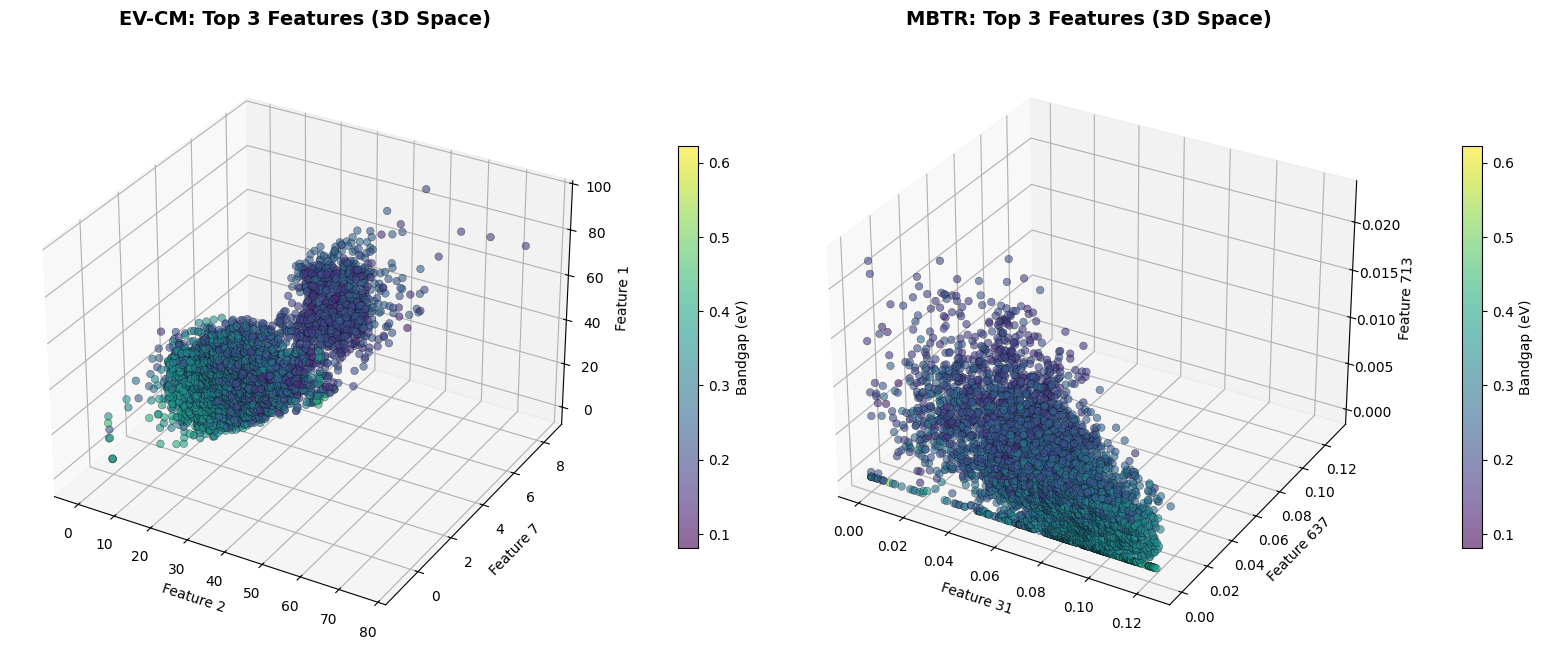

3D visualization complete!


In [ ]:
# 3D Feature Space Visualization

print("Creating 3D feature space visualizations...")

from mpl_toolkits.mplot3d import Axes3D

# Get top 3 most important features for each method
evcm_top3_idx = evcm_ranked_indices[:3]
mbtr_top3_idx = mbtr_ranked_indices[:3]

# Create 3D plots
fig = plt.figure(figsize=(16, 7))

# EV-CM 3D scatter
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    evcm_features_filtered[:, evcm_top3_idx[0]],
    evcm_features_filtered[:, evcm_top3_idx[1]],
    evcm_features_filtered[:, evcm_top3_idx[2]],
    c=y_bandgap,
    cmap='viridis',
    s=30,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.3
)
ax1.set_xlabel(f'Feature {evcm_top3_idx[0]}', fontsize=10)
ax1.set_ylabel(f'Feature {evcm_top3_idx[1]}', fontsize=10)
ax1.set_zlabel(f'Feature {evcm_top3_idx[2]}', fontsize=10)
ax1.set_title('EV-CM: Top 3 Features (3D Space)', fontsize=14, fontweight='bold', pad=20)
cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.6, pad=0.1)
cbar1.set_label('Bandgap (eV)', fontsize=10)

# MBTR 3D scatter
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    mbtr_features_filtered[:, mbtr_top3_idx[0]],
    mbtr_features_filtered[:, mbtr_top3_idx[1]],
    mbtr_features_filtered[:, mbtr_top3_idx[2]],
    c=y_bandgap,
    cmap='viridis',
    s=30,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.3
)
ax2.set_xlabel(f'Feature {mbtr_top3_idx[0]}', fontsize=10)
ax2.set_ylabel(f'Feature {mbtr_top3_idx[1]}', fontsize=10)
ax2.set_zlabel(f'Feature {mbtr_top3_idx[2]}', fontsize=10)
ax2.set_title('MBTR: Top 3 Features (3D Space)', fontsize=14, fontweight='bold', pad=20)
cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.6, pad=0.1)
cbar2.set_label('Bandgap (eV)', fontsize=10)

plt.tight_layout()
plt.show()

print("3D visualization complete!")

Analyzing feature correlations...


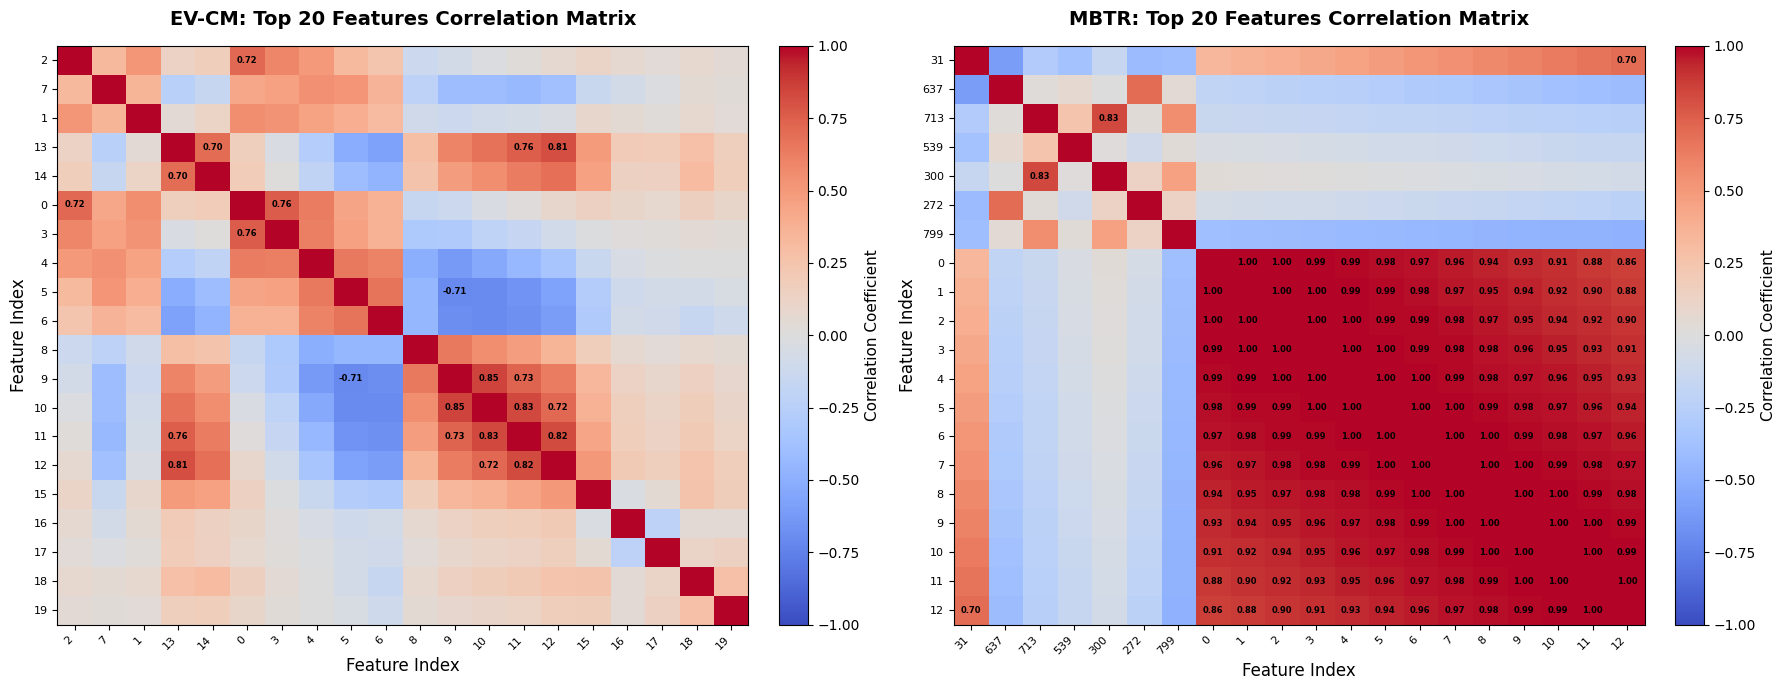


CORRELATION ANALYSIS SUMMARY

EV-CM (Top 20 Features):
  - Average absolute correlation: 0.286
  - Max correlation: 0.848
  - High correlation pairs (|r| > 0.7): 11

MBTR (Top 20 Features):
  - Average absolute correlation: 0.544
  - Max correlation: 0.999
  - High correlation pairs (|r| > 0.7): 80

Correlation analysis complete!


In [ ]:
# Feature Correlation Analysis - Top 20 Features

print("Analyzing feature correlations...")

# Get top 20 features for each method
n_top = 20
evcm_top20_idx = evcm_ranked_indices[:n_top]
mbtr_top20_idx = mbtr_ranked_indices[:n_top]

# Compute correlation matrices
evcm_top20_features = evcm_features_filtered[:, evcm_top20_idx]
mbtr_top20_features = mbtr_features_filtered[:, mbtr_top20_idx]

evcm_corr = np.corrcoef(evcm_top20_features.T)
mbtr_corr = np.corrcoef(mbtr_top20_features.T)

# Plot correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# EV-CM correlation heatmap
im1 = axes[0].imshow(evcm_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
axes[0].set_title('EV-CM: Top 20 Features Correlation Matrix',
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Feature Index', fontsize=12)
axes[0].set_ylabel('Feature Index', fontsize=12)
axes[0].set_xticks(range(n_top))
axes[0].set_yticks(range(n_top))
axes[0].set_xticklabels([f'{i}' for i in evcm_top20_idx], rotation=45, ha='right', fontsize=8)
axes[0].set_yticklabels([f'{i}' for i in evcm_top20_idx], fontsize=8)
cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
cbar1.set_label('Correlation Coefficient', fontsize=11)

# Add correlation values in cells
for i in range(n_top):
    for j in range(n_top):
        if abs(evcm_corr[i, j]) > 0.7 and i != j:  # Highlight high correlations
            text = axes[0].text(j, i, f'{evcm_corr[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=6, fontweight='bold')

# MBTR correlation heatmap
im2 = axes[1].imshow(mbtr_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
axes[1].set_title('MBTR: Top 20 Features Correlation Matrix',
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Feature Index', fontsize=12)
axes[1].set_ylabel('Feature Index', fontsize=12)
axes[1].set_xticks(range(n_top))
axes[1].set_yticks(range(n_top))
axes[1].set_xticklabels([f'{i}' for i in mbtr_top20_idx], rotation=45, ha='right', fontsize=8)
axes[1].set_yticklabels([f'{i}' for i in mbtr_top20_idx], fontsize=8)
cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label('Correlation Coefficient', fontsize=11)

# Add correlation values in cells
for i in range(n_top):
    for j in range(n_top):
        if abs(mbtr_corr[i, j]) > 0.7 and i != j:  # Highlight high correlations
            text = axes[1].text(j, i, f'{mbtr_corr[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=6, fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze correlation statistics
print("\n" + "="*60)
print("CORRELATION ANALYSIS SUMMARY")
print("="*60)

# EV-CM statistics
evcm_upper_triangle = evcm_corr[np.triu_indices_from(evcm_corr, k=1)]
evcm_high_corr = np.sum(np.abs(evcm_upper_triangle) > 0.7)
print(f"\nEV-CM (Top {n_top} Features):")
print(f"  - Average absolute correlation: {np.mean(np.abs(evcm_upper_triangle)):.3f}")
print(f"  - Max correlation: {np.max(np.abs(evcm_upper_triangle)):.3f}")
print(f"  - High correlation pairs (|r| > 0.7): {evcm_high_corr}")

# MBTR statistics
mbtr_upper_triangle = mbtr_corr[np.triu_indices_from(mbtr_corr, k=1)]
mbtr_high_corr = np.sum(np.abs(mbtr_upper_triangle) > 0.7)
print(f"\nMBTR (Top {n_top} Features):")
print(f"  - Average absolute correlation: {np.mean(np.abs(mbtr_upper_triangle)):.3f}")
print(f"  - Max correlation: {np.max(np.abs(mbtr_upper_triangle)):.3f}")
print(f"  - High correlation pairs (|r| > 0.7): {mbtr_high_corr}")

print("\nCorrelation analysis complete!")

Creating residual analysis plots...


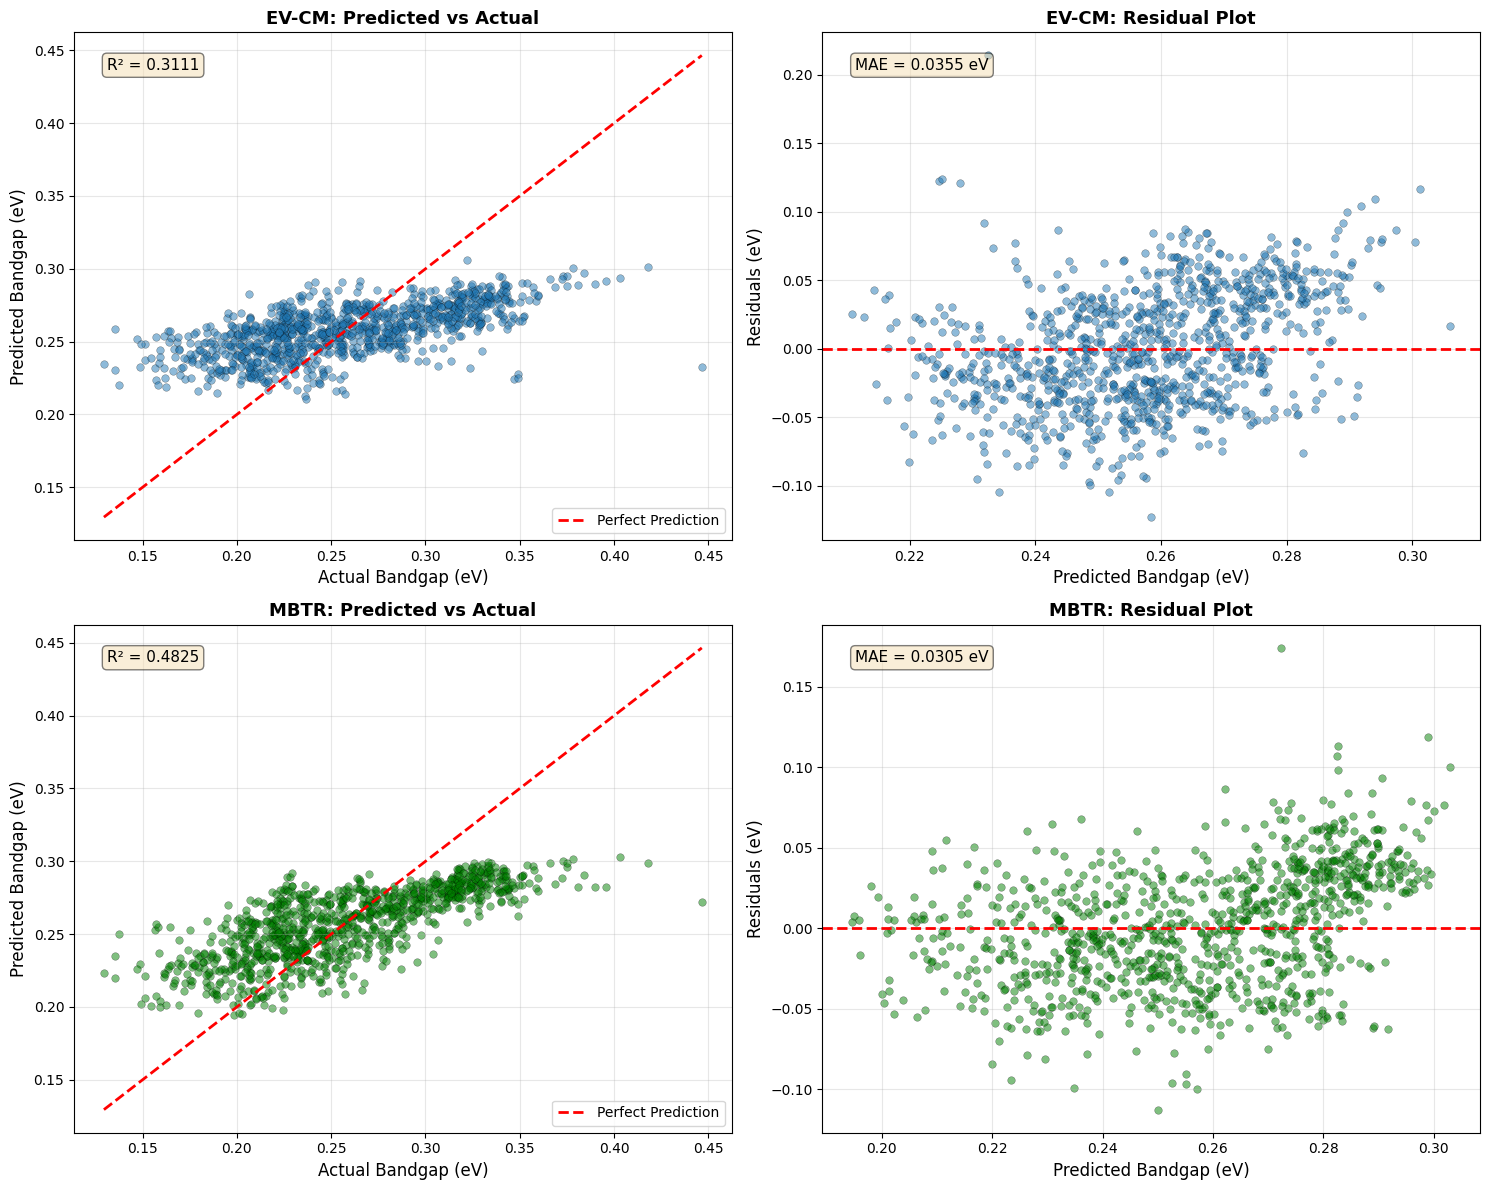

Residual analysis complete!


In [ ]:
# Prediction Quality Analysis: Residual Plots

print("Creating residual analysis plots...")

# Train final models and get predictions
def get_predictions(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    return y_test, y_pred

# Get predictions for both methods
evcm_y_test, evcm_y_pred = get_predictions(evcm_features_filtered, y_bandgap)
mbtr_y_test, mbtr_y_pred = get_predictions(mbtr_features_filtered, y_bandgap)

# Calculate residuals
evcm_residuals = evcm_y_test - evcm_y_pred
mbtr_residuals = mbtr_y_test - mbtr_y_pred

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# EV-CM: Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(evcm_y_test, evcm_y_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.3)
min_val, max_val = min(evcm_y_test.min(), evcm_y_pred.min()), max(evcm_y_test.max(), evcm_y_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Bandgap (eV)', fontsize=12)
ax1.set_ylabel('Predicted Bandgap (eV)', fontsize=12)
ax1.set_title('EV-CM: Predicted vs Actual', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
r2 = r2_score(evcm_y_test, evcm_y_pred)
ax1.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax1.transAxes,
         fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# EV-CM: Residuals vs Predicted
ax2 = axes[0, 1]
ax2.scatter(evcm_y_pred, evcm_residuals, alpha=0.5, s=30, edgecolors='k', linewidth=0.3)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted Bandgap (eV)', fontsize=12)
ax2.set_ylabel('Residuals (eV)', fontsize=12)
ax2.set_title('EV-CM: Residual Plot', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
mae = mean_absolute_error(evcm_y_test, evcm_y_pred)
ax2.text(0.05, 0.95, f'MAE = {mae:.4f} eV', transform=ax2.transAxes,
         fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# MBTR: Predicted vs Actual
ax3 = axes[1, 0]
ax3.scatter(mbtr_y_test, mbtr_y_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.3, color='green')
min_val, max_val = min(mbtr_y_test.min(), mbtr_y_pred.min()), max(mbtr_y_test.max(), mbtr_y_pred.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Bandgap (eV)', fontsize=12)
ax3.set_ylabel('Predicted Bandgap (eV)', fontsize=12)
ax3.set_title('MBTR: Predicted vs Actual', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
r2 = r2_score(mbtr_y_test, mbtr_y_pred)
ax3.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax3.transAxes,
         fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# MBTR: Residuals vs Predicted
ax4 = axes[1, 1]
ax4.scatter(mbtr_y_pred, mbtr_residuals, alpha=0.5, s=30, edgecolors='k', linewidth=0.3, color='green')
ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Bandgap (eV)', fontsize=12)
ax4.set_ylabel('Residuals (eV)', fontsize=12)
ax4.set_title('MBTR: Residual Plot', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
mae = mean_absolute_error(mbtr_y_test, mbtr_y_pred)
ax4.text(0.05, 0.95, f'MAE = {mae:.4f} eV', transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("Residual analysis complete!")

Creating comprehensive summary dashboard...


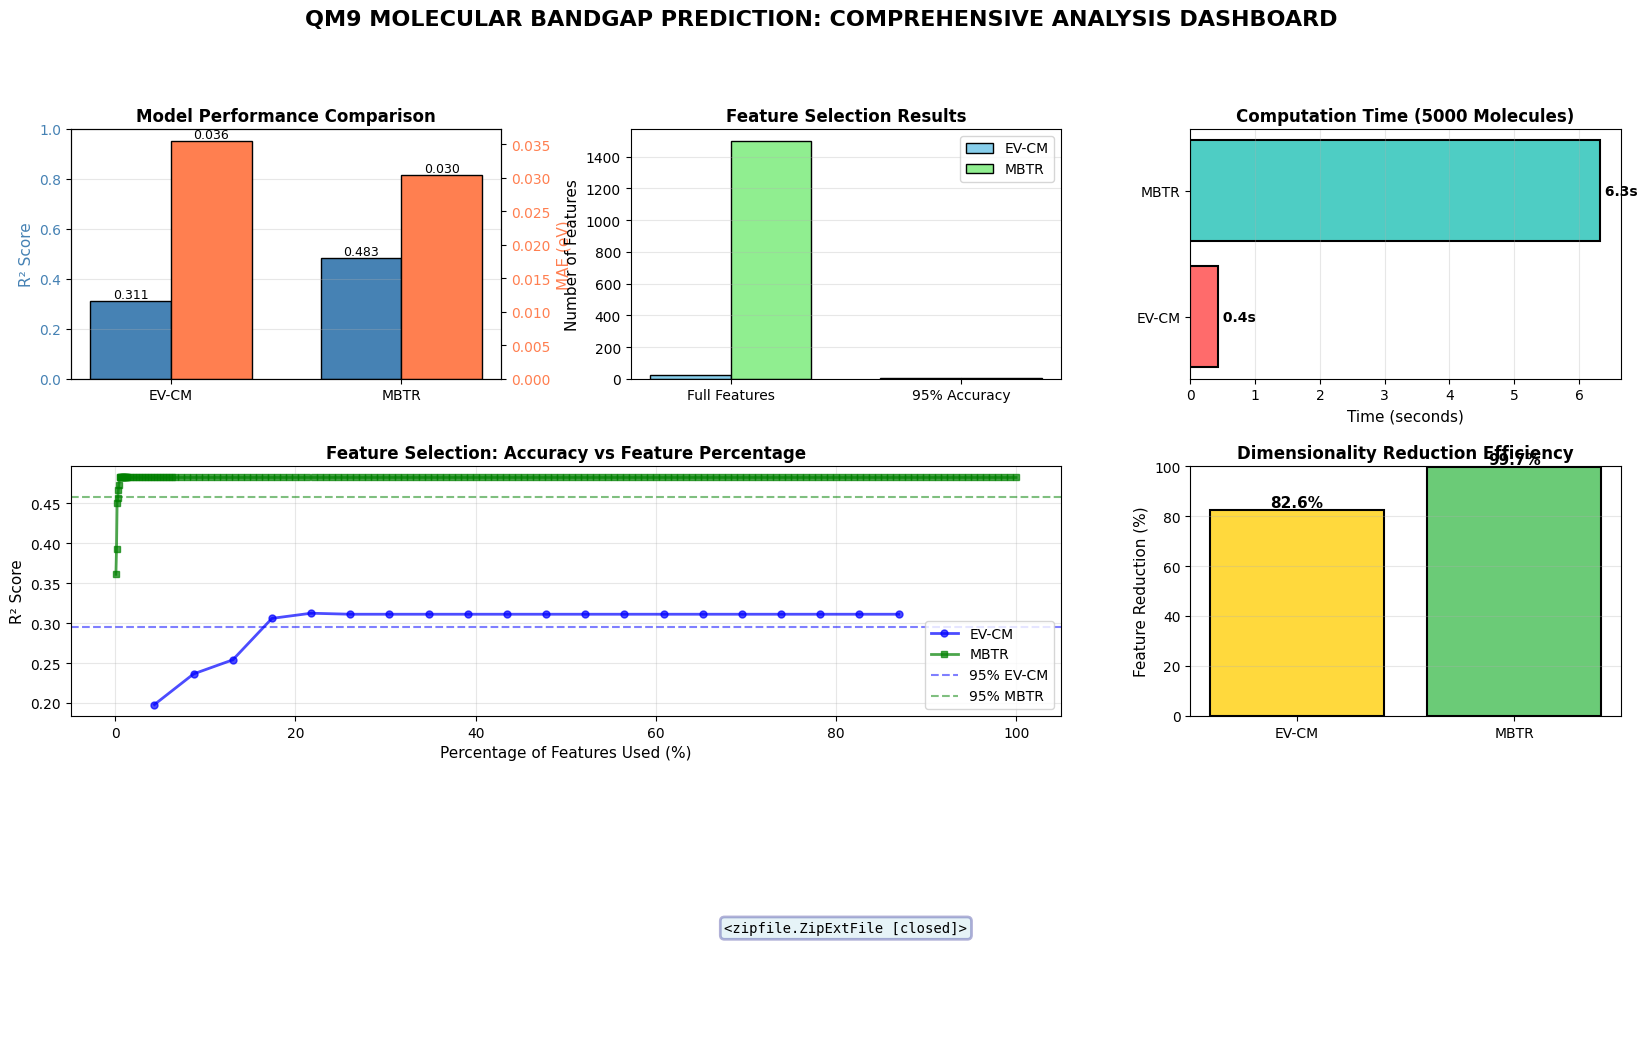

In [ ]:
# Professional Summary Dashboard

print("Creating comprehensive summary dashboard...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Performance Comparison (Top-Left)
ax1 = fig.add_subplot(gs[0, 0])
methods = ['EV-CM', 'MBTR']
test_r2 = [evcm_results['test_r2'], mbtr_results['test_r2']]
test_mae = [evcm_results['test_mae'], mbtr_results['test_mae']]

x = np.arange(len(methods))
width = 0.35
bars1 = ax1.bar(x - width/2, test_r2, width, label='R² Score', color='steelblue', edgecolor='black')
ax1_twin = ax1.twinx()
bars2 = ax1_twin.bar(x + width/2, test_mae, width, label='MAE (eV)', color='coral', edgecolor='black')

ax1.set_ylabel('R² Score', fontsize=11, color='steelblue')
ax1_twin.set_ylabel('MAE (eV)', fontsize=11, color='coral')
ax1.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1_twin.tick_params(axis='y', labelcolor='coral')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1_twin.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Feature Count Comparison (Top-Center)
ax2 = fig.add_subplot(gs[0, 1])
categories = ['Full Features', '95% Accuracy']
evcm_counts = [evcm_features_filtered.shape[1], evcm_best_n]
mbtr_counts = [mbtr_features_filtered.shape[1], mbtr_best_n]

x = np.arange(len(categories))
width = 0.35
ax2.bar(x - width/2, evcm_counts, width, label='EV-CM', color='skyblue', edgecolor='black')
ax2.bar(x + width/2, mbtr_counts, width, label='MBTR', color='lightgreen', edgecolor='black')
ax2.set_ylabel('Number of Features', fontsize=11)
ax2.set_title('Feature Selection Results', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(categories, fontsize=10)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Execution Time (Top-Right)
ax3 = fig.add_subplot(gs[0, 2])
time_data = [evcm_time_full, mbtr_time_full]
colors_time = ['#FF6B6B', '#4ECDC4']
bars = ax3.barh(methods, time_data, color=colors_time, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Time (seconds)', fontsize=11)
ax3.set_title('Computation Time (5000 Molecules)', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
            f' {width:.1f}s', ha='left', va='center', fontsize=10, fontweight='bold')

# 4. Accuracy Degradation (Middle-Left, spanning 2 columns)
ax4 = fig.add_subplot(gs[1, :2])

# Extract data from selection results (list of dictionaries)
evcm_n_features = [r['n_features'] for r in evcm_selection_results]
evcm_r2_values = [r['test_r2'] for r in evcm_selection_results]
evcm_percentages = [(n / evcm_features_filtered.shape[1]) * 100 for n in evcm_n_features]

mbtr_n_features = [r['n_features'] for r in mbtr_selection_results]
mbtr_r2_values = [r['test_r2'] for r in mbtr_selection_results]
mbtr_percentages = [(n / mbtr_features_filtered.shape[1]) * 100 for n in mbtr_n_features]

ax4.plot(evcm_percentages, evcm_r2_values,
         'o-', linewidth=2, markersize=5, label='EV-CM', color='blue', alpha=0.7)
ax4.plot(mbtr_percentages, mbtr_r2_values,
         's-', linewidth=2, markersize=5, label='MBTR', color='green', alpha=0.7)
ax4.axhline(y=0.95*evcm_results['test_r2'], color='blue', linestyle='--', alpha=0.5, label='95% EV-CM')
ax4.axhline(y=0.95*mbtr_results['test_r2'], color='green', linestyle='--', alpha=0.5, label='95% MBTR')
ax4.set_xlabel('Percentage of Features Used (%)', fontsize=11)
ax4.set_ylabel('R² Score', fontsize=11)
ax4.set_title('Feature Selection: Accuracy vs Feature Percentage', fontsize=12, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

# 5. Feature Reduction Efficiency (Middle-Right)
ax5 = fig.add_subplot(gs[1, 2])
reduction_evcm = ((evcm_features_filtered.shape[1] - evcm_best_n) / evcm_features_filtered.shape[1]) * 100
reduction_mbtr = ((mbtr_features_filtered.shape[1] - mbtr_best_n) / mbtr_features_filtered.shape[1]) * 100
reductions = [reduction_evcm, reduction_mbtr]
colors_reduction = ['#FFD93D', '#6BCB77']
bars = ax5.bar(methods, reductions, color=colors_reduction, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('Feature Reduction (%)', fontsize=11)
ax5.set_title('Dimensionality Reduction Efficiency', fontsize=12, fontweight='bold')
ax5.set_ylim(0, 100)
ax5.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 6. Key Findings (Bottom, spanning all columns)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

findings_text = f


ax6.text(0.5, 0.5, findings_text,
         transform=ax6.transAxes,
         fontsize=10,
         verticalalignment='center',
         horizontalalignment='center',
         family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, edgecolor='navy', linewidth=2))

# Main title
fig.suptitle('QM9 MOLECULAR BANDGAP PREDICTION: COMPREHENSIVE ANALYSIS DASHBOARD',
             fontsize=16, fontweight='bold', y=0.98)

plt.show()


